# ARC-AGI-2 Meta-Learning Approach

## Overview
This notebook implements a meta-learning approach for the ARC-AGI-2 competition. The goal is to create an algorithm that can quickly adapt to novel abstract reasoning tasks with just a few examples.

## Imports

In [1]:
# Standard libraries
import os
import json
import time
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Any, Optional, Union
from collections import defaultdict

# Deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Progress monitoring
from tqdm.notebook import tqdm

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Print GPU info
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("No GPU available, using CPU")

Using device: cuda
Using GPU: NVIDIA L4
GPU Memory: 23.92 GB


## Data Preparation

In [2]:
def load_data(filepath):
    """Load ARC tasks from a JSON file."""
    with open(filepath, 'r') as f:
        return json.load(f)

def load_solutions(filepath):
    """Load ARC solutions from a JSON file."""
    with open(filepath, 'r') as f:
        return json.load(f)

# Load training data with Kaggle paths
train_challenges = load_data('/kaggle/input/arc-prize-2025/arc-agi_training_challenges.json')
train_solutions = load_solutions('/kaggle/input/arc-prize-2025/arc-agi_training_solutions.json')

# Load evaluation data
eval_challenges = load_data('/kaggle/input/arc-prize-2025/arc-agi_evaluation_challenges.json')
eval_solutions = load_solutions('/kaggle/input/arc-prize-2025/arc-agi_evaluation_solutions.json')

# Load test data (will be replaced during submission)
test_challenges = load_data('/kaggle/input/arc-prize-2025/arc-agi_test_challenges.json')

print(f"Loaded {len(train_challenges)} training tasks")
print(f"Loaded {len(eval_challenges)} evaluation tasks")
print(f"Loaded {len(test_challenges)} test tasks")

Loaded 1000 training tasks
Loaded 120 evaluation tasks
Loaded 240 test tasks


## Inspect Data Structures

In [3]:
def print_data_structure(data, max_depth=3, indent=0, current_depth=0):
    """Print the structure of nested data."""
    if current_depth >= max_depth:
        print(" " * indent + "...")
        return
    
    if isinstance(data, dict):
        print(" " * indent + "{")
        for key, value in list(data.items())[:3]:  # Limit to first 3 items
            print(" " * (indent + 2) + f"{repr(key)}: ", end="")
            print_data_structure(value, max_depth, 0, current_depth + 1)
        if len(data) > 3:
            print(" " * (indent + 2) + "... and " + str(len(data) - 3) + " more items")
        print(" " * indent + "}")
    elif isinstance(data, list):
        if len(data) == 0:
            print("[]")
        else:
            print(" " * indent + "[")
            for item in data[:3]:  # Limit to first 3 items
                print(" " * (indent + 2), end="")
                print_data_structure(item, max_depth, 0, current_depth + 1)
            if len(data) > 3:
                print(" " * (indent + 2) + "... and " + str(len(data) - 3) + " more items")
            print(" " * indent + "]")
    else:
        print(repr(data))

def inspect_task_structure(task_id, task, verbose=True):
    """Print the structure of a task to understand its format."""
    if verbose:
        print(f"Task ID: {task_id}")
        print("Task keys:", list(task.keys()))
        
        print("\nTrain data:")
        for i, pair in enumerate(task['train']):
            print(f"  Pair {i+1}:")
            print(f"    Input shape: {np.array(pair['input']).shape}")
            print(f"    Output shape: {np.array(pair['output']).shape}")
    
    # Inspect test data more carefully
    test_data = task['test']
    if verbose:
        print("\nTest data type:", type(test_data))
    
    if isinstance(test_data, list):
        # Check if it's a direct grid (list of lists of integers)
        if all(isinstance(item, list) and all(isinstance(x, int) for x in item) for item in test_data):
            if verbose:
                print(f"  Test input is a grid with shape: {np.array(test_data).shape}")
            return {'type': 'direct_grid', 'shape': np.array(test_data).shape}
        # Check if it's a list of test cases (dictionaries)
        elif all(isinstance(item, dict) for item in test_data):
            if verbose:
                print(f"  Test has {len(test_data)} cases")
                for i, test_case in enumerate(test_data):
                    print(f"    Case {i+1} keys: {list(test_case.keys())}")
                    if 'input' in test_case:
                        print(f"    Input shape: {np.array(test_case['input']).shape}")
            return {'type': 'multiple_cases', 'count': len(test_data)}
    elif isinstance(test_data, dict):
        if verbose:
            print(f"  Test keys: {list(test_data.keys())}")
            if 'input' in test_data:
                print(f"  Test input shape: {np.array(test_data['input']).shape}")
        return {'type': 'dict', 'keys': list(test_data.keys())}
    
    if verbose:
        print(f"  Unrecognized test data type: {type(test_data)}")
    return {'type': 'unknown'}

def extract_test_input(task):
    """Extract test input grid(s) from a task, handling different formats."""
    test_data = task['test']
    
    if isinstance(test_data, list):
        # Check if it's a direct grid (list of lists of integers)
        if len(test_data) > 0 and all(isinstance(item, list) for item in test_data):
            if all(isinstance(x, int) for x in test_data[0]):
                return [test_data]  # Return as a list containing one grid
        
        # Check if it's a list of test cases (dictionaries)
        if all(isinstance(item, dict) for item in test_data):
            return [test_case['input'] for test_case in test_data if 'input' in test_case]
    
    # If it's a dictionary with an input key
    elif isinstance(test_data, dict) and 'input' in test_data:
        return [test_data['input']]
    
    # Fallback
    print(f"Warning: Could not extract test input from task, unknown format: {type(test_data)}")
    return []

def extract_solution_grid(solution):
    """
    Extract solution grid(s) from solution data, handling different formats and arbitrary nesting.
    Returns a list of grids.
    """
    def is_valid_grid(item):
        """Check if an item is a valid grid (list of lists of integers)."""
        if not isinstance(item, list):
            return False
        if not all(isinstance(row, list) for row in item):
            return False
        if not all(all(isinstance(cell, (int, float, bool, np.int64, np.int32, np.float64)) for cell in row) for row in item):
            return False
        return True
    
    def search_for_grid(item, depth=0, max_depth=10):
        """Recursively search for grids in nested structures."""
        if depth > max_depth:  # Prevent infinite recursion
            return []
        
        grids = []
        
        # Direct grid case
        if is_valid_grid(item):
            grids.append(item)
            return grids
        
        # Dictionary with 'output' key
        if isinstance(item, dict) and 'output' in item:
            output = item['output']
            if is_valid_grid(output):
                grids.append(output)
            else:
                # If output is not a direct grid, search within it
                grids.extend(search_for_grid(output, depth + 1, max_depth))
            return grids
        
        # List case - search each element
        if isinstance(item, list):
            # First check if this might be a direct grid with non-standard types
            # (but only if no valid grids are found through standard search)
            
            # Recursively search each element
            for element in item:
                grids.extend(search_for_grid(element, depth + 1, max_depth))
        
        return grids
    
    # Start the recursive search
    found_grids = search_for_grid(solution)
    
    # If no grids found, try a more permissive approach with numpy type handling
    if not found_grids and isinstance(solution, list):
        # Handle the common case where the first element is our grid
        if len(solution) > 0 and isinstance(solution[0], list):
            potential_grid = solution[0]
            # Convert any non-standard numeric types to integers
            try:
                grid = [[int(cell) for cell in row] for row in potential_grid]
                found_grids.append(grid)
            except (TypeError, ValueError):
                pass
    
    # If still not found, print detailed debug info
    if not found_grids:
        print(f"Warning: Could not extract grid from solution, unknown format: {type(solution)}")
        
        if isinstance(solution, list):
            print("Solution structure dump (limited):")
            print(f"  solution is a list with {len(solution)} elements")
            
            if len(solution) > 0:
                print(f"  First element type: {type(solution[0])}")
                
                if isinstance(solution[0], list) and len(solution[0]) > 0:
                    print(f"  solution[0] is a list with {len(solution[0])} elements")
                    print(f"  First element of solution[0] type: {type(solution[0][0])}")
                    
                    if isinstance(solution[0][0], list) and len(solution[0][0]) > 0:
                        print(f"  solution[0][0] is a list with {len(solution[0][0])} elements")
                        if len(solution[0][0]) > 0:
                            val = solution[0][0][0]
                            print(f"  First element of solution[0][0]: {val} (type: {type(val)})")
    
    return found_grids

## Functions for Visualization

In [4]:
def visualize_grid(grid, title="Grid", cmap='tab10'):
    """Visualize a single grid."""
    plt.figure(figsize=(5, 5))
    cmap = plt.colormaps[cmap]
    plt.imshow(np.array(grid), cmap=cmap, vmin=0, vmax=9)
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def visualize_task(task_id, task, solutions=None):
    """Visualize a task with its train pairs and test input."""
    plt.figure(figsize=(15, 10))
    
    # Use a colormap that's compatible with newer matplotlib versions
    cmap = plt.colormaps['tab10']
    
    # Plot train pairs
    train_pairs = task['train']
    n_train = len(train_pairs)
    
    for i, pair in enumerate(train_pairs):
        # Plot input
        plt.subplot(2, n_train + 1, i + 1)
        plt.imshow(np.array(pair['input']), cmap=cmap, vmin=0, vmax=9)
        plt.title(f"Train {i+1} Input")
        plt.axis('off')
        
        # Plot output
        plt.subplot(2, n_train + 1, n_train + i + 2)
        plt.imshow(np.array(pair['output']), cmap=cmap, vmin=0, vmax=9)
        plt.title(f"Train {i+1} Output")
        plt.axis('off')
    
    # Extract and plot test input
    plt.subplot(2, n_train + 1, n_train + 1)
    test_inputs = extract_test_input(task)
    
    if test_inputs:
        # Just show the first test input for now
        plt.imshow(np.array(test_inputs[0]), cmap=cmap, vmin=0, vmax=9)
        if len(test_inputs) > 1:
            plt.title(f"Test Input 1/{len(test_inputs)}")
        else:
            plt.title("Test Input")
    else:
        plt.text(0.5, 0.5, "No test input found", ha='center', va='center', transform=plt.gca().transAxes)
    
    plt.axis('off')
    
    # Extract and plot solution if available
    if solutions and task_id in solutions:
        plt.subplot(2, n_train + 1, 2 * (n_train + 1))
        
        solution_grids = extract_solution_grid(solutions[task_id])
        if solution_grids:
            # Just show the first solution grid for now
            plt.imshow(np.array(solution_grids[0]), cmap=cmap, vmin=0, vmax=9)
            if len(solution_grids) > 1:
                plt.title(f"Ground Truth 1/{len(solution_grids)}")
            else:
                plt.title("Ground Truth")
        else:
            plt.text(0.5, 0.5, "No solution grid found", ha='center', va='center', transform=plt.gca().transAxes)
        
        plt.axis('off')
    
    plt.suptitle(f"Task ID: {task_id}")
    plt.tight_layout()
    plt.show()

## Grid Processing Utilities

In [5]:
def get_grid_shape(grid):
    """Get the shape (height, width) of a grid."""
    if not isinstance(grid, list) or len(grid) == 0:
        raise ValueError(f"Invalid grid format: {type(grid)}")
    return len(grid), len(grid[0])

def pad_grid(grid, target_shape, pad_value=0):
    """Pad a grid to the target shape."""
    height, width = get_grid_shape(grid)
    target_height, target_width = target_shape
    
    # Create a new grid with the target shape
    padded_grid = [[pad_value for _ in range(target_width)] for _ in range(target_height)]
    
    # Copy the original grid values
    for i in range(min(height, target_height)):
        for j in range(min(width, target_width)):
            padded_grid[i][j] = grid[i][j]
    
    return padded_grid

def crop_grid(grid, target_shape):
    """Crop a grid to the target shape."""
    target_height, target_width = target_shape
    
    # Create a new grid with the target shape
    cropped_grid = [[grid[i][j] for j in range(min(len(grid[0]), target_width))] 
                    for i in range(min(len(grid), target_height))]
    
    return cropped_grid

def resize_grid(grid, target_shape, pad_value=0):
    """Resize a grid to the target shape (padding or cropping as needed)."""
    height, width = get_grid_shape(grid)
    target_height, target_width = target_shape
    
    if height > target_height or width > target_width:
        # Crop if the grid is larger than the target
        return crop_grid(grid, target_shape)
    elif height < target_height or width < target_width:
        # Pad if the grid is smaller than the target
        return pad_grid(grid, target_shape, pad_value)
    else:
        # Return as is if the shapes match
        return grid

def grid_to_tensor(grid):
    """Convert a grid to a PyTorch tensor with shape (1, H, W)."""
    # Convert to numpy array first, then to tensor
    grid_array = np.array(grid, dtype=np.float32)
    # Add channel dimension
    return torch.tensor(grid_array).unsqueeze(0)

def tensor_to_grid(tensor):
    """Convert a PyTorch tensor with shape (1, H, W) to a grid."""
    # Remove channel dimension and convert to numpy array
    grid_array = tensor.squeeze(0).detach().cpu().numpy()
    # Convert to list of lists
    return grid_array.astype(int).tolist()

def normalize_grid(grid):
    """Normalize a grid by mapping its unique values to 0, 1, 2, etc."""
    flat_grid = [val for row in grid for val in row]
    unique_values = sorted(set(flat_grid))
    value_map = {val: i for i, val in enumerate(unique_values)}
    
    normalized_grid = [[value_map[val] for val in row] for row in grid]
    return normalized_grid

def preprocess_grid(grid, max_size=30):
    """Improved preprocessing for grid data that ensures proper tensor format."""
    # Ensure grid is a list or numpy array
    if not isinstance(grid, (list, np.ndarray)):
        raise ValueError(f"Grid must be a list or numpy array, got {type(grid)}")
    
    # Convert to numpy array for easier manipulation
    if isinstance(grid, list):
        grid_array = np.array(grid, dtype=np.float32)
    else:
        grid_array = grid.astype(np.float32)
    
    # Check if grid is empty or has incorrect shape
    if grid_array.size == 0 or grid_array.ndim < 2:
        raise ValueError(f"Invalid grid shape: {grid_array.shape}")
    
    # Resize if needed
    if grid_array.shape[0] > max_size or grid_array.shape[1] > max_size:
        # Use the resize_grid function if you have it, otherwise create a basic one
        height = min(grid_array.shape[0], max_size)
        width = min(grid_array.shape[1], max_size)
        grid_array = grid_array[:height, :width]
    
    # Convert to tensor (add batch and channel dimensions if needed)
    tensor = torch.tensor(grid_array, dtype=torch.float32)
    
    # Ensure tensor has at least 3 dimensions (channel, height, width)
    if tensor.dim() == 2:  # [height, width]
        tensor = tensor.unsqueeze(0)  # Add channel dimension -> [channel, height, width]
    
    # Normalize to [0, 1]
    tensor = tensor / 9.0
    
    return tensor

def postprocess_tensor(tensor, original_shape=None):
    """Improved postprocessing to convert tensor back to grid format without scalar conversion issues."""
    # Ensure tensor is on CPU and detached from graph
    tensor = tensor.detach().cpu()
    
    # Scale to [0, 9] range
    tensor = torch.clamp(tensor * 9.0, 0, 9)
    
    # Round to integers
    tensor = torch.round(tensor)
    
    # Remove extra dimensions
    if tensor.dim() == 4:  # [batch, channel, height, width]
        tensor = tensor.squeeze(0).squeeze(0)
    elif tensor.dim() == 3:  # [channel, height, width]
        tensor = tensor.squeeze(0)
    
    # Convert to numpy array
    grid_array = tensor.numpy()
    
    # Resize to original shape if provided
    if original_shape is not None:
        orig_height, orig_width = original_shape
        current_height, current_width = grid_array.shape
        
        if current_height != orig_height or current_width != orig_width:
            # Simple resizing by cropping or padding
            new_grid = np.zeros((orig_height, orig_width), dtype=np.int32)
            # Copy values from grid_array to new_grid (up to the smaller dimensions)
            h = min(current_height, orig_height)
            w = min(current_width, orig_width)
            new_grid[:h, :w] = grid_array[:h, :w]
            grid_array = new_grid
    
    # Convert to integers and then to nested Python lists
    return grid_array.astype(int).tolist()

## Dataset Class object for ARC Tasks

In [6]:
class ARCDataset(Dataset):
    """Dataset for ARC tasks."""
    def __init__(self, challenges, solutions=None, max_size=30):
        self.challenges = challenges
        self.solutions = solutions
        self.task_ids = list(challenges.keys())
        self.max_size = max_size
    
    def __len__(self):
        return len(self.task_ids)
    
    def __getitem__(self, idx):
        task_id = self.task_ids[idx]
        task = self.challenges[task_id]
        
        # Process train pairs
        train_data = []
        for pair in task['train']:
            input_grid = pair['input']
            output_grid = pair['output']
            
            # Preprocess grids
            try:
                input_tensor = preprocess_grid(input_grid, self.max_size)
                output_tensor = preprocess_grid(output_grid, self.max_size)
                train_data.append((input_tensor, output_tensor))
            except Exception as e:
                print(f"Error preprocessing train pair for task {task_id}: {str(e)}")
                continue
        
        # Process test input(s)
        test_inputs = []
        
        try:
            # Extract test input grids
            test_grids = extract_test_input(task)
            for grid in test_grids:
                test_inputs.append(preprocess_grid(grid, self.max_size))
        except Exception as e:
            print(f"Error processing test input for task {task_id}: {str(e)}")
        
        # Process test output(s) if available
        test_outputs = []
        
        if self.solutions and task_id in self.solutions:
            try:
                # Extract solution grids
                solution_grids = extract_solution_grid(self.solutions[task_id])
                for grid in solution_grids:
                    test_outputs.append(preprocess_grid(grid, self.max_size))
            except Exception as e:
                print(f"Error processing solution for task {task_id}: {str(e)}")
        
        # Fill remaining outputs with None if needed
        while len(test_outputs) < len(test_inputs):
            test_outputs.append(None)
        
        # If no test inputs were processed, add a placeholder
        if len(test_inputs) == 0:
            print(f"Warning: No valid test inputs found for task {task_id}")
            test_inputs.append(torch.zeros((1, 1, 1)))
            test_outputs.append(None)
        
        return task_id, train_data, test_inputs, test_outputs

def collate_arc_batch(batch):
    """Custom collate function for ARC batches."""
    # Each element in batch is (task_id, train_data, test_inputs, test_outputs)
    task_ids = [item[0] for item in batch]
    train_data_list = [item[1] for item in batch]
    test_inputs_list = [item[2] for item in batch]
    test_outputs_list = [item[3] for item in batch]
    
    return task_ids, train_data_list, test_inputs_list, test_outputs_list

## Data Analysis and Exploration


Analyzing training data structure:
Sample train challenge structure:
{
  'train': [
  {
  'input': ...
  'output': ...
}
  {
  'input': ...
  'output': ...
}
]
  'test': [
  {
  'input': ...
}
]
}

Sample train solution structure:
[
  [
  [
  ...
  ...
  ...
  ... and 3 more items
]
  [
  ...
  ...
  ...
  ... and 3 more items
]
  [
  ...
  ...
  ...
  ... and 3 more items
]
  ... and 3 more items
]
]

Visualizing sample training tasks:

Sample Task 1:
Task ID: 00576224
Task keys: ['train', 'test']

Train data:
  Pair 1:
    Input shape: (2, 2)
    Output shape: (6, 6)
  Pair 2:
    Input shape: (2, 2)
    Output shape: (6, 6)

Test data type: <class 'list'>
  Test has 1 cases
    Case 1 keys: ['input']
    Input shape: (2, 2)


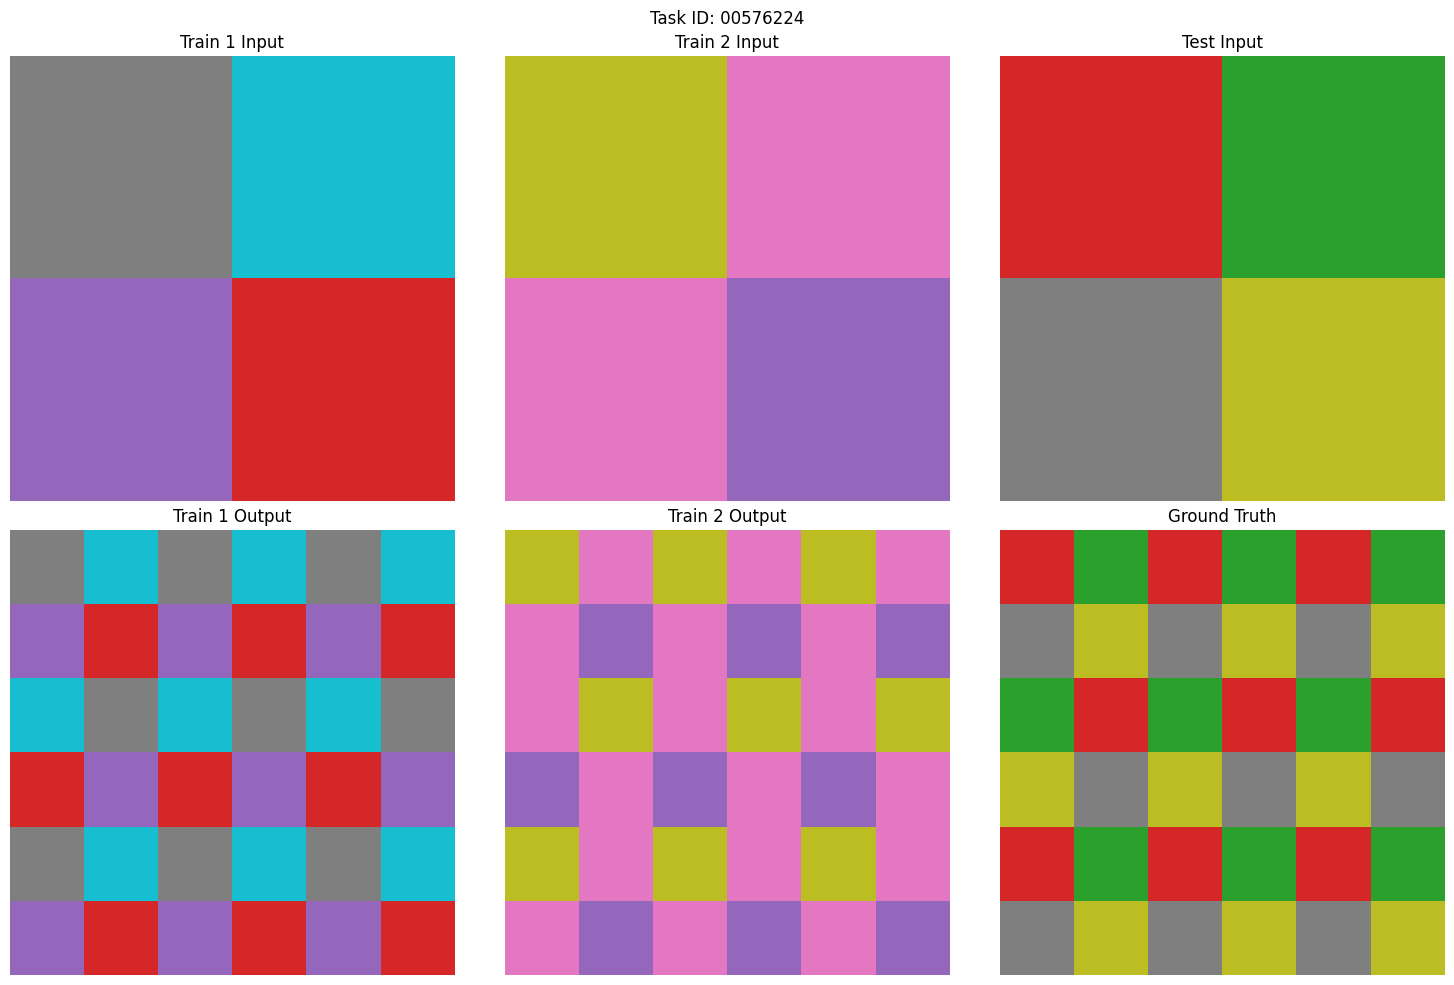


Sample Task 2:
Task ID: 007bbfb7
Task keys: ['train', 'test']

Train data:
  Pair 1:
    Input shape: (3, 3)
    Output shape: (9, 9)
  Pair 2:
    Input shape: (3, 3)
    Output shape: (9, 9)
  Pair 3:
    Input shape: (3, 3)
    Output shape: (9, 9)
  Pair 4:
    Input shape: (3, 3)
    Output shape: (9, 9)
  Pair 5:
    Input shape: (3, 3)
    Output shape: (9, 9)

Test data type: <class 'list'>
  Test has 1 cases
    Case 1 keys: ['input']
    Input shape: (3, 3)


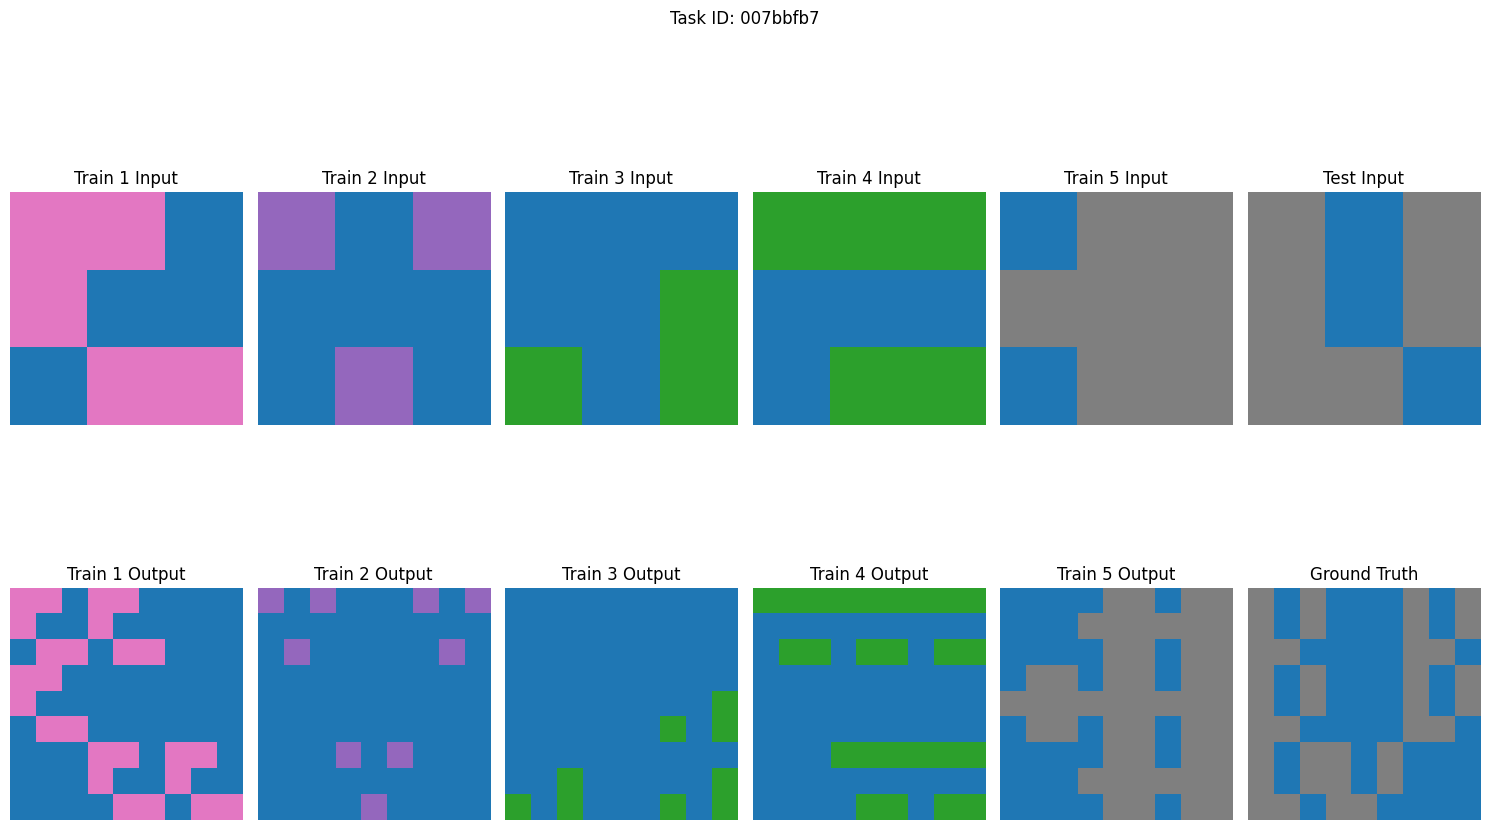


Sample Task 3:
Task ID: 009d5c81
Task keys: ['train', 'test']

Train data:
  Pair 1:
    Input shape: (14, 14)
    Output shape: (14, 14)
  Pair 2:
    Input shape: (14, 14)
    Output shape: (14, 14)
  Pair 3:
    Input shape: (14, 14)
    Output shape: (14, 14)
  Pair 4:
    Input shape: (14, 14)
    Output shape: (14, 14)
  Pair 5:
    Input shape: (14, 14)
    Output shape: (14, 14)

Test data type: <class 'list'>
  Test has 1 cases
    Case 1 keys: ['input']
    Input shape: (14, 14)


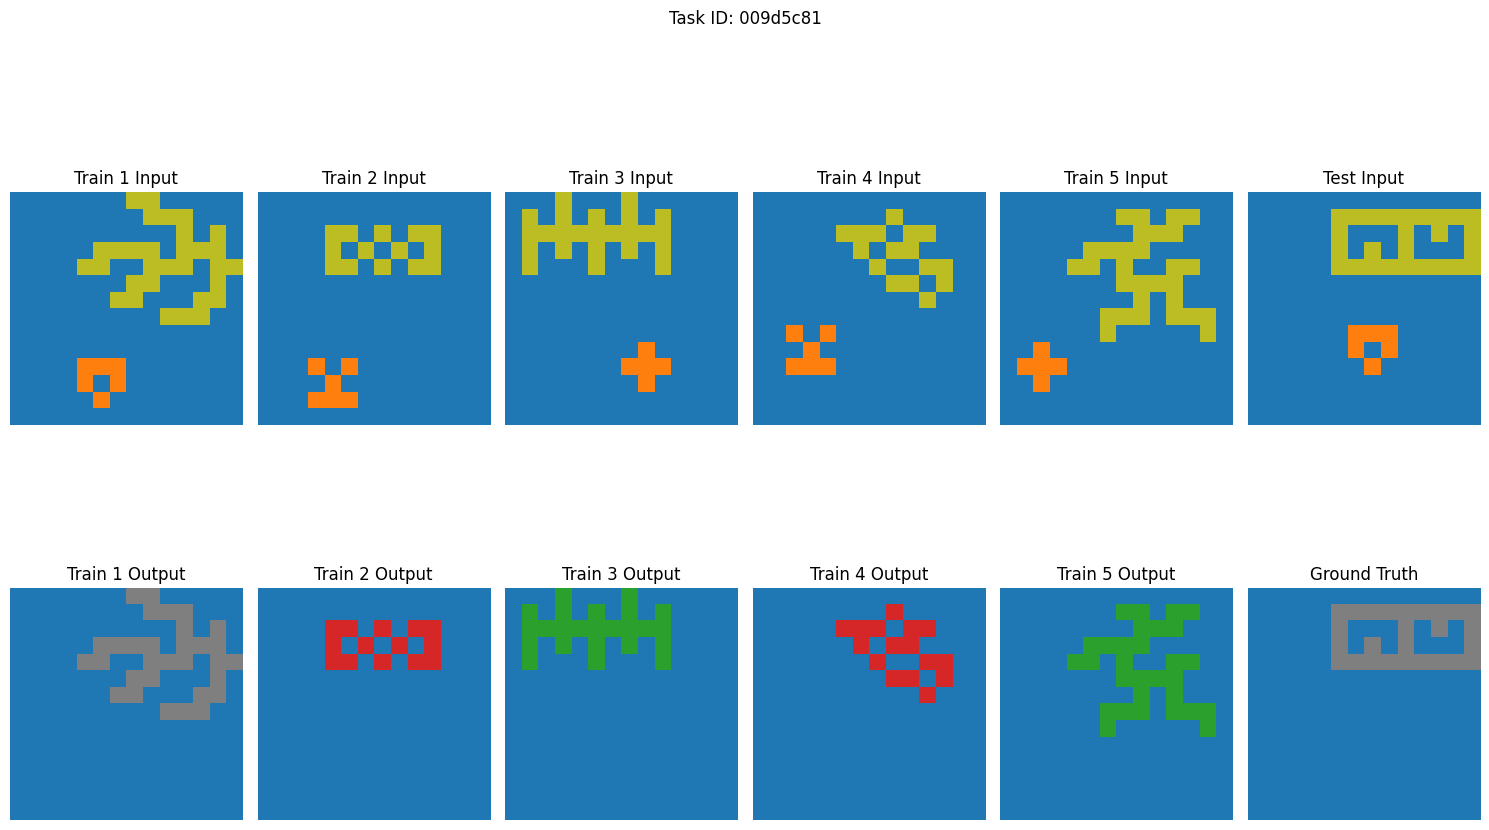


Analyzing test input formats across tasks:
Test input format distribution:
  multiple_cases: 50 tasks

Analyzing solution structures:
Solution structure distribution:
  list_containing_grid: 49 tasks
  direct_grid: 1 tasks

Testing data loading:
Batch with 2 tasks
  Task 1 (ID: 00576224):
    Number of train pairs: 2
    Number of test inputs: 1
    Number of test outputs: 1
    First train pair shapes: input (1, 2, 2), output (1, 6, 6)
    First test input shape: (1, 2, 2)
    First test output shape: (1, 6, 6)
  Task 2 (ID: 007bbfb7):
    Number of train pairs: 5
    Number of test inputs: 1
    Number of test outputs: 1
    First train pair shapes: input (1, 3, 3), output (1, 9, 9)
    First test input shape: (1, 3, 3)
    First test output shape: (1, 9, 9)


In [7]:
# Analyze the structure of training tasks and solutions
print("\nAnalyzing training data structure:")
print("Sample train challenge structure:")
if list(train_challenges.keys()):
    sample_task_id = list(train_challenges.keys())[0]
    print_data_structure(train_challenges[sample_task_id])

    print("\nSample train solution structure:")
    if sample_task_id in train_solutions:
        print_data_structure(train_solutions[sample_task_id])
    else:
        print("No solution found for sample task")

# Visualize a few sample tasks
print("\nVisualizing sample training tasks:")
for i, task_id in enumerate(list(train_challenges.keys())[:3]):
    print(f"\nSample Task {i+1}:")
    try:
        inspect_task_structure(task_id, train_challenges[task_id])
        visualize_task(task_id, train_challenges[task_id], train_solutions)
    except Exception as e:
        print(f"Error visualizing task: {str(e)}")

# Analyze test input formats
print("\nAnalyzing test input formats across tasks:")
test_formats = {}
for i, task_id in enumerate(list(train_challenges.keys())[:50]):  # Sample first 50 tasks
    try:
        task = train_challenges[task_id]
        format_info = inspect_task_structure(task_id, task, verbose=False)
        format_type = format_info['type']
        
        if format_type not in test_formats:
            test_formats[format_type] = 0
        test_formats[format_type] += 1
    except Exception:
        continue

print("Test input format distribution:")
for format_type, count in test_formats.items():
    print(f"  {format_type}: {count} tasks")

# Analyze solution structures
print("\nAnalyzing solution structures:")
solution_types = {}
for i, task_id in enumerate(list(train_solutions.keys())[:50]):  # Sample first 50 tasks
    solution = train_solutions[task_id]
    
    # Determine the solution type
    if isinstance(solution, list):
        if len(solution) == 0:
            solution_type = "empty_list"
        elif len(solution) == 1 and isinstance(solution[0], list) and all(isinstance(row, list) for row in solution[0]):
            solution_type = "list_containing_grid"
        elif all(isinstance(item, list) for item in solution):
            solution_type = "direct_grid"
        elif all(isinstance(item, dict) for item in solution):
            solution_type = "list_of_dicts"
        else:
            solution_type = "other_list"
    elif isinstance(solution, dict):
        solution_type = "dict"
    else:
        solution_type = "other"
    
    if solution_type not in solution_types:
        solution_types[solution_type] = 0
    solution_types[solution_type] += 1

print("Solution structure distribution:")
for solution_type, count in solution_types.items():
    print(f"  {solution_type}: {count} tasks")

# Test the dataset
print("\nTesting data loading:")
sample_dataset = ARCDataset(
    {k: train_challenges[k] for k in list(train_challenges.keys())[:5]},
    {k: train_solutions[k] for k in list(train_solutions.keys())[:5]}
)

sample_loader = DataLoader(
    sample_dataset,
    batch_size=2,
    shuffle=False,
    collate_fn=collate_arc_batch
)

for task_ids, train_data_list, test_inputs_list, test_outputs_list in sample_loader:
    print(f"Batch with {len(task_ids)} tasks")
    for i, (task_id, train_data, test_inputs, test_outputs) in enumerate(zip(task_ids, train_data_list, test_inputs_list, test_outputs_list)):
        print(f"  Task {i+1} (ID: {task_id}):")
        print(f"    Number of train pairs: {len(train_data)}")
        print(f"    Number of test inputs: {len(test_inputs)}")
        print(f"    Number of test outputs: {len(test_outputs)}")
        
        # Print shapes of the first train pair and test input/output
        if train_data:
            input_tensor, output_tensor = train_data[0]
            print(f"    First train pair shapes: input {tuple(input_tensor.shape)}, output {tuple(output_tensor.shape)}")
        
        if test_inputs:
            print(f"    First test input shape: {tuple(test_inputs[0].shape)}")
        
        if test_outputs and test_outputs[0] is not None:
            print(f"    First test output shape: {tuple(test_outputs[0].shape)}")
        else:
            print("    No test output available")
    
    # Only process one batch for this example
    break

## Analysis of Submission Format

In [8]:
print("\nExpected submission format:")
submission_example = {
    "task_id_1": [{"attempt_1": [[0, 0], [0, 0]], "attempt_2": [[1, 1], [0, 0]]}],
    "task_id_2": [
        {"attempt_1": [[0, 0], [0, 0]], "attempt_2": [[0, 0], [0, 0]]},
        {"attempt_1": [[0, 0], [0, 0]], "attempt_2": [[0, 0], [0, 0]]}
    ]
}

print_data_structure(submission_example)
print("Each task ID maps to a list of prediction objects.")
print("Each prediction object contains 'attempt_1' and 'attempt_2' for two prediction attempts.")
print("For tasks with multiple test inputs, the list contains multiple prediction objects.")


Expected submission format:
{
  'task_id_1': [
  {
  'attempt_1': ...
  'attempt_2': ...
}
]
  'task_id_2': [
  {
  'attempt_1': ...
  'attempt_2': ...
}
  {
  'attempt_1': ...
  'attempt_2': ...
}
]
}
Each task ID maps to a list of prediction objects.
Each prediction object contains 'attempt_1' and 'attempt_2' for two prediction attempts.
For tasks with multiple test inputs, the list contains multiple prediction objects.


## Neural Network Models for Meta-Learning

In [9]:
def ensure_same_dimensions(prediction, target):
    """
    Ensures prediction and target tensors have the same dimensions
    for proper loss calculation.
    """
    # Convert both tensors to 4D if needed: [batch, channel, height, width]
    if prediction.dim() < 4:
        if prediction.dim() == 3:  # [channel, height, width]
            prediction = prediction.unsqueeze(0)
        elif prediction.dim() == 2:  # [height, width]
            prediction = prediction.unsqueeze(0).unsqueeze(0)
    
    if target.dim() < 4:
        if target.dim() == 3:  # [channel, height, width]
            target = target.unsqueeze(0)
        elif target.dim() == 2:  # [height, width]
            target = target.unsqueeze(0).unsqueeze(0)
    
    # Now both should be 4D tensors
    assert prediction.dim() == 4, f"Prediction has incorrect dimensions: {prediction.shape}"
    assert target.dim() == 4, f"Target has incorrect dimensions: {target.shape}"
    
    return prediction, target

class GridEncoder(nn.Module):
    """Encodes a grid into a latent representation with improved handling for small grids."""
    def __init__(self, input_channels=1, latent_dim=128):
        super(GridEncoder, self).__init__()
        
        # CNN layers for grid encoding
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        
        # Adaptive pooling to handle variable-sized inputs - this is crucial
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        
        # Fully connected layer to latent space
        self.fc = nn.Linear(64 * 4 * 4, latent_dim)
        
    def forward(self, x):
        # Ensure the input has 4 dimensions [batch, channel, height, width]
        if len(x.shape) == 3:  # If it's [channel, height, width], add batch dimension
            x = x.unsqueeze(0)
        elif len(x.shape) == 2:  # If it's [height, width], add batch and channel dimensions
            x = x.unsqueeze(0).unsqueeze(0)
        
        # Get input size for diagnostics
        input_height, input_width = x.shape[2], x.shape[3]
        
        # Apply first convolution
        x = F.relu(self.conv1(x))
        
        # Only apply pooling if the size is large enough to prevent collapse
        if input_height >= 4 and input_width >= 4:
            x = self.pool(x)
        
        # Apply second convolution
        x = F.relu(self.conv2(x))
        
        # Only apply pooling again if the feature map is still large enough
        if x.shape[2] >= 4 and x.shape[3] >= 4:
            x = self.pool(x)
        
        # Apply third convolution
        x = F.relu(self.conv3(x))
        
        # Apply adaptive pooling to get fixed size regardless of input dimensions
        # This ensures we always get a 4x4 output regardless of input size
        x = self.adaptive_pool(x)
        
        # Flatten the tensor
        x = x.view(x.size(0), -1)
        
        # Project to latent space
        x = self.fc(x)
        
        return x

class GridDecoder(nn.Module):
    """Decodes a latent representation back to a grid."""
    def __init__(self, latent_dim=128, output_channels=1, output_size=(10, 10)):
        super(GridDecoder, self).__init__()
        self.output_size = output_size
        
        # Fully connected layer from latent to initial feature map
        self.fc = nn.Linear(latent_dim, 64 * 4 * 4)
        
        # Transposed convolution layers
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        
        # Final convolution to get the desired number of channels
        self.conv_out = nn.Conv2d(16, output_channels, kernel_size=3, padding=1)
        
        # Adaptive convolutional layers to resize to desired output dimensions
        self.upsample = nn.Upsample(size=output_size, mode='bilinear', align_corners=False)
        
    def forward(self, x):
        # Expected input shape: (batch_size, latent_dim)
        
        # Project from latent space and reshape
        x = self.fc(x)
        x = x.view(x.size(0), 64, 4, 4)
        
        # Deconvolution layers
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        
        # Final convolution
        x = self.conv_out(x)
        
        # Resize to desired output dimensions
        x = self.upsample(x)
        
        # Apply sigmoid to get values in [0, 1]
        x = torch.sigmoid(x)
        
        return x

class TransformationNetwork(nn.Module):
    """Network that learns the transformation between input and output grids."""
    def __init__(self, encoder_dim=128, hidden_dim=256, max_output_size=(30, 30)):
        super(TransformationNetwork, self).__init__()
        
        self.encoder = GridEncoder(input_channels=1, latent_dim=encoder_dim)
        
        # Size prediction network to predict the output grid size
        self.size_predictor = nn.Sequential(
            nn.Linear(encoder_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)  # Predict height and width
        )
        
        # Transformation network to process encoded inputs
        self.transform_net = nn.Sequential(
            nn.Linear(encoder_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, encoder_dim)
        )
        
        # Dynamic decoder that will be instantiated based on predicted size
        self.decoder = None
        self.max_output_size = max_output_size
        
    def predict_output_size(self, encoded_input, encoded_output=None):
        """Predict the output grid size based on the encoded input."""
        # For training, we can use the actual output size
        if encoded_output is not None:
            # This is just a placeholder during training
            # We'll use the actual output size
            return None
        
        # For inference, predict the output size
        size_logits = self.size_predictor(encoded_input)
        
        # Ensure the predicted size is reasonable
        predicted_size = torch.clamp(
            torch.round(torch.sigmoid(size_logits) * torch.tensor([30.0, 30.0]).to(encoded_input.device)),
            min=1, max=30
        ).int()
        
        return (predicted_size[0].item(), predicted_size[1].item())
    
    def forward(self, input_grid, output_grid=None, output_size=None):
        # Encode the input
        encoded_input = self.encoder(input_grid)
        
        if output_grid is not None:
            # Training mode
            encoded_output = self.encoder(output_grid)
            concat_encoding = torch.cat([encoded_input, encoded_output], dim=1)
            
            # Learn the transformation
            transformation = self.transform_net(concat_encoding)
            
            # For training, we'll use the actual output size
            actual_size = (output_grid.shape[-2], output_grid.shape[-1])  # Use -2, -1 to handle different shapes
            
            # Create decoder if it doesn't exist or if output size changed
            if self.decoder is None or getattr(self.decoder, 'output_size', None) != actual_size:
                self.decoder = GridDecoder(
                    latent_dim=encoded_input.shape[1],
                    output_size=actual_size
                ).to(input_grid.device)
            
            # Apply transformation to get predicted output encoding
            predicted_output_encoding = encoded_input + transformation
            
            # Decode to get predicted output
            predicted_output = self.decoder(predicted_output_encoding)
            
            return predicted_output
        
        else:
            # Inference mode
            # Predict output size if not provided
            if output_size is None:
                output_size = self.predict_output_size(encoded_input)
            
            # Create decoder for the predicted/provided size
            self.decoder = GridDecoder(
                latent_dim=encoded_input.shape[1],
                output_size=output_size
            ).to(input_grid.device)
            
            # For prediction, return the encoded input
            return encoded_input

class MAML(nn.Module):
    """Model-Agnostic Meta-Learning for quick adaptation to new tasks."""
    def __init__(self, model, inner_lr=0.01, meta_lr=0.001):
        super(MAML, self).__init__()
        self.model = model
        self.inner_lr = inner_lr
        self.meta_optimizer = optim.Adam(self.model.parameters(), lr=meta_lr)
        
    def adapt(self, support_data, num_steps=5):
        """Adapt the model to a new task using the support data."""
        # Create a copy of the model for adaptation
        adapted_model = copy.deepcopy(self.model)
        adapted_model.train()
        
        # Set up an optimizer for adaptation
        optimizer = optim.SGD(adapted_model.parameters(), lr=self.inner_lr)
        
        # Collect output sizes for decoder creation
        output_sizes = []
        for input_grid, output_grid in support_data:
            if input_grid is None or output_grid is None:
                continue
                
            # Get the actual grid dimensions (handle different tensor shapes)
            if len(output_grid.shape) >= 3:  # [batch/channel, height, width] or [batch, channel, height, width]
                output_sizes.append((output_grid.shape[-2], output_grid.shape[-1]))  # Use last two dimensions
            elif len(output_grid.shape) == 2:  # [height, width]
                output_sizes.append((output_grid.shape[0], output_grid.shape[1]))
            else:
                # Skip invalid shapes
                continue
        
        # Use most common output size for efficiency
        if not output_sizes:
            # Default fallback if no valid sizes
            most_common_size = (10, 10)
        else:
            output_size_counts = {}
            for size in output_sizes:
                if size not in output_size_counts:
                    output_size_counts[size] = 0
                output_size_counts[size] += 1
            most_common_size = max(output_size_counts.items(), key=lambda x: x[1])[0]
        
        # Create decoder for this adaptation session
        adapted_model.decoder = GridDecoder(
            latent_dim=adapted_model.encoder.fc.out_features,
            output_size=most_common_size
        ).to(device)
        
        # Filter out invalid support data
        valid_support_data = []
        for input_grid, output_grid in support_data:
            if input_grid is not None and output_grid is not None:
                valid_support_data.append((input_grid, output_grid))
        
        if not valid_support_data:
            return adapted_model  # Return unadapted model if no valid data
        
        for _ in range(num_steps):
            total_loss = 0
            
            for input_grid, output_grid in valid_support_data:
                try:
                    # Forward pass
                    predicted_output = adapted_model(input_grid, output_grid)
                    
                    # Ensure dimensions match for loss calculation
                    predicted_output, output_grid = ensure_same_dimensions(predicted_output, output_grid)
                    
                    # Compute loss
                    loss = F.mse_loss(predicted_output, output_grid)
                    
                    # Backward pass and optimization
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                    total_loss += loss.item()
                except Exception as e:
                    continue  # Skip on error
        
        return adapted_model
    
    def meta_learn(self, task_batch, num_inner_steps=5):
        """Perform meta-learning on a batch of tasks with improved gradient flow."""
        meta_loss_tensor = None
        count = 0
        
        for support_data, query_data in task_batch:
            # Skip if no support or query data
            if not support_data or not query_data:
                continue
                
            try:
                # Adapt the model to the task
                adapted_model = self.adapt(support_data, num_steps=num_inner_steps)
                
                # Compute loss on query set with the adapted model
                query_loss_tensor = None
                query_count = 0
                
                for input_grid, output_grid in query_data:
                    try:
                        # Forward pass with adapted model
                        predicted_output = adapted_model(input_grid, output_grid)
                        
                        # Ensure dimensions match for loss calculation
                        predicted_output, output_grid = ensure_same_dimensions(predicted_output, output_grid)
                        
                        # Compute loss and accumulate as tensor to preserve gradients
                        loss = F.mse_loss(predicted_output, output_grid)
                        if query_loss_tensor is None:
                            query_loss_tensor = loss
                        else:
                            query_loss_tensor = query_loss_tensor + loss
                        query_count += 1
                    except Exception as e:
                        print(f"Error in query prediction: {str(e)}")
                        continue
                
                # Average query loss
                if query_count > 0 and query_loss_tensor is not None:
                    query_loss_tensor = query_loss_tensor / query_count
                    if meta_loss_tensor is None:
                        meta_loss_tensor = query_loss_tensor
                    else:
                        meta_loss_tensor = meta_loss_tensor + query_loss_tensor
                    count += 1
            except Exception as e:
                print(f"Error in meta_learn: {str(e)}")
                continue
        
        # Average meta loss and apply gradients
        if count > 0 and meta_loss_tensor is not None:
            meta_loss_tensor = meta_loss_tensor / count
            
            # Update the model with the meta-gradient
            self.meta_optimizer.zero_grad()
            meta_loss_tensor.backward()
            self.meta_optimizer.step()
            
            return meta_loss_tensor.item()
        else:
            # Return 0 if no tasks were processed
            return 0.0
    
    def predict(self, support_data, query_input, num_adaptation_steps=10, attempt=1):
        """Make a prediction for a query input after adapting on support data."""
        # Adapt the model to the task
        adapted_model = self.adapt(support_data, num_steps=num_adaptation_steps)
        adapted_model.eval()
    
        with torch.no_grad():
            # Ensure query_input has correct dimensions
            if query_input.dim() < 3:
                query_input = query_input.unsqueeze(0)  # Add channel dimension if needed
            if query_input.dim() < 4:
                query_input = query_input.unsqueeze(0)  # Add batch dimension if needed
        
            # Encode the query input
            encoded_query = adapted_model.encoder(query_input)
        
            # Compute average transformation from support data
            avg_transformation = torch.zeros_like(encoded_query)
            count = 0
        
            # Try to infer the output size from the support data
            output_sizes = []
            size_counts = {}
        
            for input_grid, output_grid in support_data:
                if input_grid is None or output_grid is None:
                    continue
            
                try:
                    # Get the actual grid dimensions (handle different tensor shapes)
                    if len(output_grid.shape) >= 3:  # [batch/channel, height, width] or [batch, channel, height, width]
                        output_size = (output_grid.shape[-2], output_grid.shape[-1])  # Use last two dimensions
                    elif len(output_grid.shape) == 2:  # [height, width]
                        output_size = (output_grid.shape[0], output_grid.shape[1])
                    else:
                        continue  # Skip invalid shapes
                
                    output_sizes.append(output_size)
                
                    if output_size not in size_counts:
                        size_counts[output_size] = 0
                    size_counts[output_size] += 1
                
                    # Ensure input_grid has correct dimensions before encoding
                    in_grid = input_grid
                    if in_grid.dim() < 3:
                        in_grid = in_grid.unsqueeze(0)  # Add channel dimension
                    if in_grid.dim() < 4:
                        in_grid = in_grid.unsqueeze(0)  # Add batch dimension
                
                    # Ensure output_grid has correct dimensions before encoding
                    out_grid = output_grid
                    if out_grid.dim() < 3:
                        out_grid = out_grid.unsqueeze(0)  # Add channel dimension
                    if out_grid.dim() < 4:
                        out_grid = out_grid.unsqueeze(0)  # Add batch dimension
                
                    # Encode support input and output
                    encoded_input = adapted_model.encoder(in_grid)
                    encoded_output = adapted_model.encoder(out_grid)
                
                    # Compute transformation
                    concat_encoding = torch.cat([encoded_input, encoded_output], dim=1)
                    transformation = adapted_model.transform_net(concat_encoding)
                
                    avg_transformation = avg_transformation + transformation
                    count += 1
                except Exception as e:
                    print(f"Error in transformation computation: {str(e)}")
                    continue
        
            if count > 0:
                avg_transformation = avg_transformation / count
        
            # Apply the transformation
            predicted_encoding = encoded_query + avg_transformation
        
            # Choose output size based on attempt
            if not size_counts:
                predicted_size = (10, 10)  # Default fallback
            elif attempt == 1:
                # For first attempt, use the most common size in support data
                if size_counts:
                    predicted_size = max(size_counts.items(), key=lambda x: x[1])[0]
                else:
                    predicted_size = (10, 10)
            else:
                # For second attempt, use a different approach
                if len(size_counts) > 1:
                    # Sort sizes by count in descending order
                    sorted_sizes = sorted(size_counts.items(), key=lambda x: x[1], reverse=True)
                    if len(sorted_sizes) > 1:
                        predicted_size = sorted_sizes[1][0]  # Second most common
                    else:
                        predicted_size = sorted_sizes[0][0]  # Use the most common if only one exists
                else:
                    # Use the size predictor instead of direct tensor access
                    size_logits = adapted_model.size_predictor(encoded_query)
                    size_height = torch.clamp(torch.round(torch.sigmoid(size_logits[0, 0]) * 30.0), min=1, max=30).int().item()
                    size_width = torch.clamp(torch.round(torch.sigmoid(size_logits[0, 1]) * 30.0), min=1, max=30).int().item()
                    predicted_size = (size_height, size_width)
        
            # Create decoder for the predicted size
            adapted_model.decoder = GridDecoder(
                latent_dim=encoded_query.shape[1],
                output_size=predicted_size
            ).to(device)
        
            # Decode to get the predicted output
            predicted_output = adapted_model.decoder(predicted_encoding)
        
            return predicted_output

## Functions Relevant to Training and Evaluation

In [10]:
def prepare_task_batch(task_ids, train_data_list, test_inputs_list, test_outputs_list, split_ratio=0.7):
    """Prepare a batch of tasks for meta-learning."""
    task_batch = []
    
    for train_data, test_inputs, test_outputs in zip(train_data_list, test_inputs_list, test_outputs_list):
        # Skip tasks without valid test outputs
        valid_outputs = [output for output in test_outputs if output is not None]
        if not valid_outputs:
            continue
        
        # If we only have train data and one test input/output,
        # use part of the train data as support and part as query
        if len(train_data) >= 2 and len(valid_outputs) == 1:
            # Split train data into support and query
            split_idx = max(1, int(len(train_data) * split_ratio))
            support_data = train_data[:split_idx]
            
            # Use the rest of train data as query data
            query_data = train_data[split_idx:]
            
            # Add test example to query data if available
            for test_input, test_output in zip(test_inputs, test_outputs):
                if test_output is not None:
                    query_data.append((test_input, test_output))
        else:
            # Use all train data as support
            support_data = train_data
            
            # Use test inputs/outputs as query data
            query_data = []
            for test_input, test_output in zip(test_inputs, test_outputs):
                if test_output is not None:
                    query_data.append((test_input, test_output))
        
        # Skip if either support or query is empty
        if support_data and query_data:
            task_batch.append((support_data, query_data))
    
    return task_batch

def meta_train(model, train_loader, val_loader, num_epochs=50, inner_steps=5, log_interval=10):
    """Train the meta-learning model."""
    best_val_loss = float('inf')
    best_model_state = None
    training_losses = []
    validation_losses = []
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        batch_count = 0
        
        for batch_idx, (task_ids, train_data_list, test_inputs_list, test_outputs_list) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            # Prepare task batch
            task_batch = prepare_task_batch(task_ids, train_data_list, test_inputs_list, test_outputs_list)
            
            # Skip if no valid tasks
            if not task_batch:
                continue
            
            # Move data to device
            device_task_batch = []
            for support_data, query_data in task_batch:
                device_support = [(input_grid.to(device), output_grid.to(device)) 
                                 for input_grid, output_grid in support_data]
                device_query = [(input_grid.to(device), output_grid.to(device)) 
                               for input_grid, output_grid in query_data]
                device_task_batch.append((device_support, device_query))
            
            # Perform meta-learning
            try:
                loss = model.meta_learn(device_task_batch, num_inner_steps=inner_steps)
                train_loss += loss
                batch_count += 1
                
                if (batch_idx + 1) % log_interval == 0:
                    print(f"Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss:.6f}")
            except Exception as e:
                print(f"Error in batch {batch_idx+1}: {str(e)}")
                continue
        
        # Compute average training loss
        avg_train_loss = train_loss / max(1, batch_count)
        training_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {avg_train_loss:.6f}")
        
        # Validation
        model.eval()
        val_loss = 0
        val_batch_count = 0
        
        with torch.no_grad():
            for task_ids, train_data_list, test_inputs_list, test_outputs_list in tqdm(val_loader, desc="Validation"):
                # Prepare task batch
                task_batch = prepare_task_batch(task_ids, train_data_list, test_inputs_list, test_outputs_list)
                
                # Skip if no valid tasks
                if not task_batch:
                    continue
                
                # Move data to device
                device_task_batch = []
                for support_data, query_data in task_batch:
                    device_support = [(input_grid.to(device), output_grid.to(device)) 
                                     for input_grid, output_grid in support_data]
                    device_query = [(input_grid.to(device), output_grid.to(device)) 
                                   for input_grid, output_grid in query_data]
                    device_task_batch.append((device_support, device_query))
                
                # For each task in the batch
                for support_data, query_data in device_task_batch:
                    try:
                        # Adapt the model
                        adapted_model = model.adapt(support_data, num_steps=inner_steps)
                        
                        # Compute loss on query set
                        task_loss = 0
                        query_count = 0
                        
                        for input_grid, output_grid in query_data:
                            # Forward pass with adapted model
                            predicted_output = adapted_model(input_grid, output_grid)
                            
                            # Ensure dimensions match for loss calculation
                            predicted_output, output_grid = ensure_same_dimensions(predicted_output, output_grid)
                            
                            # Compute loss
                            loss = F.mse_loss(predicted_output, output_grid)
                            task_loss += loss.item()
                            query_count += 1
                        
                        # Average loss for this task
                        if query_count > 0:
                            task_loss /= query_count
                            val_loss += task_loss
                            val_batch_count += 1
                    except Exception as e:
                        continue  # Skip on error
        
        # Compute average validation loss
        avg_val_loss = val_loss / max(1, val_batch_count)
        validation_losses.append(avg_val_loss)
        print(f"Validation Loss: {avg_val_loss:.6f}")
        
        # Save the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            torch.save(best_model_state, 'best_maml_model.pt')
            print("Saved new best model")
    
    # Load the best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    # Plot training and validation losses
    plt.figure(figsize=(10, 6))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_plot.png')
    plt.show()
    
    return model, training_losses, validation_losses

def evaluate_model(model, eval_loader, num_adaptation_steps=10):
    """Evaluate the model on the evaluation dataset."""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for task_ids, train_data_list, test_inputs_list, test_outputs_list in tqdm(eval_loader, desc="Evaluating"):
            for task_id, train_data, test_inputs, test_outputs in zip(task_ids, train_data_list, test_inputs_list, test_outputs_list):
                # Skip tasks without test outputs
                valid_test_pairs = [(test_input, test_output) 
                                   for test_input, test_output in zip(test_inputs, test_outputs) 
                                   if test_output is not None]
                
                if not valid_test_pairs:
                    continue
                
                # Move train data to device
                device_train_data = [(input_grid.to(device), output_grid.to(device)) 
                                    for input_grid, output_grid in train_data]
                
                # Process each test case
                for test_input, test_output in valid_test_pairs:
                    try:
                        # Move test data to device
                        test_input = test_input.to(device)
                        test_output = test_output.to(device)
                        
                        # Make predictions (2 attempts)
                        pred1 = model.predict(device_train_data, test_input, 
                                             num_adaptation_steps=num_adaptation_steps, attempt=1)
                        pred2 = model.predict(device_train_data, test_input, 
                                             num_adaptation_steps=num_adaptation_steps, attempt=2)
                        
                        # Convert predictions and target to grids
                        pred1_grid = postprocess_tensor(pred1)
                        pred2_grid = postprocess_tensor(pred2)
                        target_grid = postprocess_tensor(test_output)
                        
                        # Check if either prediction matches the target
                        # Convert to numpy for comparison
                        pred1_np = np.array(pred1_grid)
                        pred2_np = np.array(pred2_grid)
                        target_np = np.array(target_grid)
                        
                        # Check if shapes match
                        if pred1_np.shape == target_np.shape and np.array_equal(pred1_np, target_np):
                            correct += 1
                            total += 1
                            continue
                        
                        if pred2_np.shape == target_np.shape and np.array_equal(pred2_np, target_np):
                            correct += 1
                            total += 1
                            continue
                        
                        # If we get here, neither prediction matched
                        total += 1
                    except Exception as e:
                        print(f"Error comparing predictions for task {task_id}: {str(e)}")
                        total += 1
    
    accuracy = correct / total if total > 0 else 0
    print(f"Evaluation accuracy: {accuracy:.4f} ({correct}/{total})")
    return accuracy

def generate_submission(model, test_challenges, output_path='submission.json', num_adaptation_steps=10):
    """Generate a submission file for the competition."""
    model.eval()
    submission = {}
    
    # Process each test task
    for task_id, task in tqdm(test_challenges.items(), desc="Generating predictions"):
        # Process train pairs
        train_data = []
        try:
            for pair in task['train']:
                input_grid = preprocess_grid(pair['input'])
                output_grid = preprocess_grid(pair['output'])
                train_data.append((input_grid.to(device), output_grid.to(device)))
            
            # Extract test input grids
            test_grids = extract_test_input(task)
            
            # Generate predictions for each test input
            test_predictions = []
            for i, grid in enumerate(test_grids):
                try:
                    test_input = preprocess_grid(grid).to(device)
                    
                    # Make two prediction attempts
                    pred1 = model.predict(train_data, test_input, 
                                         num_adaptation_steps=num_adaptation_steps, attempt=1)
                    pred2 = model.predict(train_data, test_input, 
                                         num_adaptation_steps=num_adaptation_steps, attempt=2)
                    
                    # Convert to grids
                    pred1_grid = postprocess_tensor(pred1)
                    pred2_grid = postprocess_tensor(pred2)
                    
                    # Add to predictions
                    test_predictions.append({
                        "attempt_1": pred1_grid,
                        "attempt_2": pred2_grid
                    })
                except Exception as e:
                    print(f"Error generating predictions for test input {i} in task {task_id}: {str(e)}")
                    # Provide a fallback prediction
                    test_predictions.append({
                        "attempt_1": [[0, 0], [0, 0]],
                        "attempt_2": [[0, 0], [0, 0]]
                    })
        except Exception as e:
            print(f"Error processing task {task_id}: {str(e)}")
            # Provide a fallback prediction
            test_predictions.append({
                "attempt_1": [[0, 0], [0, 0]],
                "attempt_2": [[0, 0], [0, 0]]
            })
        
        # Add to submission
        submission[task_id] = test_predictions
    
    # Save submission to file
    with open(output_path, 'w') as f:
        json.dump(submission, f)
    
    print(f"Submission saved to {output_path}")
    return submission

## Debugger

In [11]:
def debug_solution_extraction(task_id, solution):
    """Debug a specific solution extraction."""
    print(f"Debugging solution extraction for task: {task_id}")
    print(f"Solution type: {type(solution)}")
    
    if isinstance(solution, list):
        print(f"Solution length: {len(solution)}")
        if len(solution) > 0:
            print(f"First element type: {type(solution[0])}")
            if isinstance(solution[0], list):
                print(f"First element length: {len(solution[0])}")
                if len(solution[0]) > 0:
                    print(f"First row type: {type(solution[0][0])}")
                    if isinstance(solution[0][0], list):
                        print(f"First row length: {len(solution[0][0])}")
                        if len(solution[0][0]) > 0:
                            first_cell = solution[0][0][0]
                            print(f"First cell: {first_cell} (type: {type(first_cell)})")
                            print(f"Is int: {isinstance(first_cell, int)}")
                            print(f"Is like int: {hasattr(first_cell, '__int__')}")
    
    result = extract_solution_grid(solution)
    print(f"Extraction result: {result[:1] if result else '[]'}")
    
    return result

# Test with a specific task
sample_task_id = list(train_solutions.keys())[0]
debug_solution_extraction(sample_task_id, train_solutions[sample_task_id])

Debugging solution extraction for task: 00576224
Solution type: <class 'list'>
Solution length: 1
First element type: <class 'list'>
First element length: 6
First row type: <class 'list'>
First row length: 6
First cell: 3 (type: <class 'int'>)
Is int: True
Is like int: True
Extraction result: [[[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, 3, 2, 3, 2, 3], [8, 7, 8, 7, 8, 7], [3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8]]]


[[[3, 2, 3, 2, 3, 2],
  [7, 8, 7, 8, 7, 8],
  [2, 3, 2, 3, 2, 3],
  [8, 7, 8, 7, 8, 7],
  [3, 2, 3, 2, 3, 2],
  [7, 8, 7, 8, 7, 8]]]

## Main Execution

Creating datasets...
Creating data loaders...
Initializing model...
Starting meta-training...


Epoch 1/30:   0%|          | 0/125 [00:00<?, ?it/s]

Batch 5/125, Loss: 0.127813
Batch 10/125, Loss: 0.139564
Batch 15/125, Loss: 0.137510
Batch 20/125, Loss: 0.166077
Batch 25/125, Loss: 0.170542
Batch 30/125, Loss: 0.121097
Batch 35/125, Loss: 0.143698
Batch 40/125, Loss: 0.147310
Batch 45/125, Loss: 0.174290
Batch 50/125, Loss: 0.143344
Batch 55/125, Loss: 0.169930
Batch 60/125, Loss: 0.148085
Batch 65/125, Loss: 0.172038
Batch 70/125, Loss: 0.165224
Batch 75/125, Loss: 0.156880
Batch 80/125, Loss: 0.163464
Batch 85/125, Loss: 0.171981
Batch 90/125, Loss: 0.147957
Batch 95/125, Loss: 0.144733
Batch 100/125, Loss: 0.140396
Batch 105/125, Loss: 0.113062
Batch 110/125, Loss: 0.182352
Batch 115/125, Loss: 0.159039
Batch 120/125, Loss: 0.151037
Batch 125/125, Loss: 0.126053
Epoch 1/30, Average Training Loss: 0.153380


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.119338
Saved new best model


Epoch 2/30:   0%|          | 0/125 [00:00<?, ?it/s]

Batch 5/125, Loss: 0.131009
Batch 10/125, Loss: 0.155584
Batch 15/125, Loss: 0.125033
Batch 20/125, Loss: 0.177642
Batch 25/125, Loss: 0.166883
Batch 30/125, Loss: 0.177327
Batch 35/125, Loss: 0.155413
Batch 40/125, Loss: 0.151739
Batch 45/125, Loss: 0.129883
Batch 50/125, Loss: 0.150816
Batch 55/125, Loss: 0.098474
Batch 60/125, Loss: 0.147286
Batch 65/125, Loss: 0.176410
Batch 70/125, Loss: 0.135045
Batch 75/125, Loss: 0.172513
Batch 80/125, Loss: 0.163100
Batch 85/125, Loss: 0.168640
Batch 90/125, Loss: 0.135879
Batch 95/125, Loss: 0.172421
Batch 100/125, Loss: 0.134167
Batch 105/125, Loss: 0.148051
Batch 110/125, Loss: 0.169631
Batch 115/125, Loss: 0.142511
Batch 120/125, Loss: 0.137330
Batch 125/125, Loss: 0.113348
Epoch 2/30, Average Training Loss: 0.153108


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.119335
Saved new best model


Epoch 3/30:   0%|          | 0/125 [00:00<?, ?it/s]

Batch 5/125, Loss: 0.153048
Batch 10/125, Loss: 0.170563
Batch 15/125, Loss: 0.125939
Batch 20/125, Loss: 0.166006
Batch 25/125, Loss: 0.176464
Batch 30/125, Loss: 0.140469
Batch 35/125, Loss: 0.181383
Batch 40/125, Loss: 0.159572
Batch 45/125, Loss: 0.145733
Batch 50/125, Loss: 0.144405
Batch 55/125, Loss: 0.144214
Batch 60/125, Loss: 0.196150
Batch 65/125, Loss: 0.203891
Batch 70/125, Loss: 0.151578
Batch 75/125, Loss: 0.175045
Batch 80/125, Loss: 0.158949
Batch 85/125, Loss: 0.151647
Batch 90/125, Loss: 0.160313
Batch 95/125, Loss: 0.144987
Batch 100/125, Loss: 0.128580
Batch 105/125, Loss: 0.119542
Batch 110/125, Loss: 0.133177
Batch 115/125, Loss: 0.167332
Batch 120/125, Loss: 0.138815
Batch 125/125, Loss: 0.169090
Epoch 3/30, Average Training Loss: 0.153104


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.119853


Epoch 4/30:   0%|          | 0/125 [00:00<?, ?it/s]

Batch 5/125, Loss: 0.151947
Batch 10/125, Loss: 0.145547
Batch 15/125, Loss: 0.161824
Batch 20/125, Loss: 0.147526
Batch 25/125, Loss: 0.150024
Batch 30/125, Loss: 0.176882
Batch 35/125, Loss: 0.159539
Batch 40/125, Loss: 0.117483
Batch 45/125, Loss: 0.147309
Batch 50/125, Loss: 0.157372
Batch 55/125, Loss: 0.164012
Batch 60/125, Loss: 0.153453
Batch 65/125, Loss: 0.187643
Batch 70/125, Loss: 0.133313
Batch 75/125, Loss: 0.156623
Batch 80/125, Loss: 0.164294
Batch 85/125, Loss: 0.142952
Batch 90/125, Loss: 0.153084
Batch 95/125, Loss: 0.144310
Batch 100/125, Loss: 0.172319
Batch 105/125, Loss: 0.145210
Batch 110/125, Loss: 0.135679
Batch 115/125, Loss: 0.190827
Batch 120/125, Loss: 0.174960
Batch 125/125, Loss: 0.165140
Epoch 4/30, Average Training Loss: 0.153186


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.118132
Saved new best model


Epoch 5/30:   0%|          | 0/125 [00:00<?, ?it/s]

Batch 5/125, Loss: 0.141910
Batch 10/125, Loss: 0.165840
Batch 15/125, Loss: 0.141928
Batch 20/125, Loss: 0.184710
Batch 25/125, Loss: 0.157132
Batch 30/125, Loss: 0.163121
Batch 35/125, Loss: 0.126562
Batch 40/125, Loss: 0.176722
Batch 45/125, Loss: 0.155522
Batch 50/125, Loss: 0.142363
Batch 55/125, Loss: 0.141088
Batch 60/125, Loss: 0.127591
Batch 65/125, Loss: 0.144096
Batch 70/125, Loss: 0.157769
Batch 75/125, Loss: 0.162001
Batch 80/125, Loss: 0.148022
Batch 85/125, Loss: 0.123097
Batch 90/125, Loss: 0.148140
Batch 95/125, Loss: 0.150467
Batch 100/125, Loss: 0.172504
Batch 105/125, Loss: 0.121348
Batch 110/125, Loss: 0.142734
Batch 115/125, Loss: 0.123200
Batch 120/125, Loss: 0.149259
Batch 125/125, Loss: 0.187377
Epoch 5/30, Average Training Loss: 0.153548


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.118688


Epoch 6/30:   0%|          | 0/125 [00:00<?, ?it/s]

Batch 5/125, Loss: 0.151555
Batch 10/125, Loss: 0.156198
Batch 15/125, Loss: 0.143041
Batch 20/125, Loss: 0.133693
Batch 25/125, Loss: 0.113739
Batch 30/125, Loss: 0.187389
Batch 35/125, Loss: 0.167345
Batch 40/125, Loss: 0.142302
Batch 45/125, Loss: 0.150292
Batch 50/125, Loss: 0.156422
Batch 55/125, Loss: 0.155287
Batch 60/125, Loss: 0.132154
Batch 65/125, Loss: 0.158449
Batch 70/125, Loss: 0.131729
Batch 75/125, Loss: 0.156474
Batch 80/125, Loss: 0.139236
Batch 85/125, Loss: 0.138742
Batch 90/125, Loss: 0.112956
Batch 95/125, Loss: 0.172059
Batch 100/125, Loss: 0.138312
Batch 105/125, Loss: 0.166199
Batch 110/125, Loss: 0.106268
Batch 115/125, Loss: 0.162251
Batch 120/125, Loss: 0.160398
Batch 125/125, Loss: 0.160746
Epoch 6/30, Average Training Loss: 0.153224


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.119172


Epoch 7/30:   0%|          | 0/125 [00:00<?, ?it/s]

Batch 5/125, Loss: 0.159751
Batch 10/125, Loss: 0.165982
Batch 15/125, Loss: 0.110996
Batch 20/125, Loss: 0.165997
Batch 25/125, Loss: 0.199174
Batch 30/125, Loss: 0.166807
Batch 35/125, Loss: 0.147651
Batch 40/125, Loss: 0.125650
Batch 45/125, Loss: 0.156429
Batch 50/125, Loss: 0.158873
Batch 55/125, Loss: 0.101824
Batch 60/125, Loss: 0.161940
Batch 65/125, Loss: 0.177569
Batch 70/125, Loss: 0.189254
Batch 75/125, Loss: 0.181523
Batch 80/125, Loss: 0.164087
Batch 85/125, Loss: 0.166081
Batch 90/125, Loss: 0.126271
Batch 95/125, Loss: 0.187631
Batch 100/125, Loss: 0.174725
Batch 105/125, Loss: 0.163930
Batch 110/125, Loss: 0.120397
Batch 115/125, Loss: 0.110562
Batch 120/125, Loss: 0.142781
Batch 125/125, Loss: 0.166647
Epoch 7/30, Average Training Loss: 0.153327


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.118988


Epoch 8/30:   0%|          | 0/125 [00:00<?, ?it/s]

Batch 5/125, Loss: 0.158302
Batch 10/125, Loss: 0.172441
Batch 15/125, Loss: 0.151225
Batch 20/125, Loss: 0.160179
Batch 25/125, Loss: 0.148910
Batch 30/125, Loss: 0.188467
Batch 35/125, Loss: 0.127377
Batch 40/125, Loss: 0.160328
Batch 45/125, Loss: 0.166383
Batch 50/125, Loss: 0.147951
Batch 55/125, Loss: 0.136820
Batch 60/125, Loss: 0.128882
Batch 65/125, Loss: 0.140859
Batch 70/125, Loss: 0.176458
Batch 75/125, Loss: 0.157835
Batch 80/125, Loss: 0.187386
Batch 85/125, Loss: 0.174019
Batch 90/125, Loss: 0.141277
Batch 95/125, Loss: 0.162070
Batch 100/125, Loss: 0.101102
Batch 105/125, Loss: 0.146786
Batch 110/125, Loss: 0.174553
Batch 115/125, Loss: 0.113658
Batch 120/125, Loss: 0.153206
Batch 125/125, Loss: 0.124935
Epoch 8/30, Average Training Loss: 0.153552


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.118748


Epoch 9/30:   0%|          | 0/125 [00:00<?, ?it/s]

Batch 5/125, Loss: 0.156797
Batch 10/125, Loss: 0.149912
Batch 15/125, Loss: 0.139098
Batch 20/125, Loss: 0.128173
Batch 25/125, Loss: 0.159718
Batch 30/125, Loss: 0.121673
Batch 35/125, Loss: 0.155139
Batch 40/125, Loss: 0.166932
Batch 45/125, Loss: 0.122190
Batch 50/125, Loss: 0.206706
Batch 55/125, Loss: 0.129720
Batch 60/125, Loss: 0.108896
Batch 65/125, Loss: 0.160368
Batch 70/125, Loss: 0.129273
Batch 75/125, Loss: 0.170249
Batch 80/125, Loss: 0.126220
Batch 85/125, Loss: 0.145465
Batch 90/125, Loss: 0.173597
Batch 95/125, Loss: 0.168172
Batch 100/125, Loss: 0.184949
Batch 105/125, Loss: 0.127854
Batch 110/125, Loss: 0.177336
Batch 115/125, Loss: 0.153334
Batch 120/125, Loss: 0.173846
Batch 125/125, Loss: 0.123530
Epoch 9/30, Average Training Loss: 0.153392


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.118573


Epoch 10/30:   0%|          | 0/125 [00:00<?, ?it/s]

Batch 5/125, Loss: 0.188441
Batch 10/125, Loss: 0.163829
Batch 15/125, Loss: 0.175456
Batch 20/125, Loss: 0.172045
Batch 25/125, Loss: 0.171405
Batch 30/125, Loss: 0.211213
Batch 35/125, Loss: 0.157166
Batch 40/125, Loss: 0.160841
Batch 45/125, Loss: 0.174416
Batch 50/125, Loss: 0.169508
Batch 55/125, Loss: 0.133501
Batch 60/125, Loss: 0.181677
Batch 65/125, Loss: 0.156379
Batch 70/125, Loss: 0.135409
Batch 75/125, Loss: 0.156033
Batch 80/125, Loss: 0.153078
Batch 85/125, Loss: 0.105920
Batch 90/125, Loss: 0.172016
Batch 95/125, Loss: 0.127206
Batch 100/125, Loss: 0.142943
Batch 105/125, Loss: 0.188538
Batch 110/125, Loss: 0.143744
Batch 115/125, Loss: 0.172023
Batch 120/125, Loss: 0.148600
Batch 125/125, Loss: 0.198929
Epoch 10/30, Average Training Loss: 0.153215


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.119345


Epoch 11/30:   0%|          | 0/125 [00:00<?, ?it/s]

Batch 5/125, Loss: 0.160685
Batch 10/125, Loss: 0.159725
Batch 15/125, Loss: 0.152115
Batch 20/125, Loss: 0.159684
Batch 25/125, Loss: 0.149725
Batch 30/125, Loss: 0.169555
Batch 35/125, Loss: 0.152005
Batch 40/125, Loss: 0.180472
Batch 45/125, Loss: 0.167845
Batch 50/125, Loss: 0.174269
Batch 55/125, Loss: 0.172870
Batch 60/125, Loss: 0.105874
Batch 65/125, Loss: 0.103029
Batch 70/125, Loss: 0.136080
Batch 75/125, Loss: 0.125865
Batch 80/125, Loss: 0.147925
Batch 85/125, Loss: 0.166849
Batch 90/125, Loss: 0.163936
Batch 95/125, Loss: 0.104136
Batch 100/125, Loss: 0.181226
Batch 105/125, Loss: 0.128351
Batch 110/125, Loss: 0.134362
Batch 115/125, Loss: 0.109396
Batch 120/125, Loss: 0.131873
Batch 125/125, Loss: 0.160108
Epoch 11/30, Average Training Loss: 0.153351


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.119693


Epoch 12/30:   0%|          | 0/125 [00:00<?, ?it/s]

Batch 5/125, Loss: 0.167809
Batch 10/125, Loss: 0.150066
Batch 15/125, Loss: 0.137280
Batch 20/125, Loss: 0.143324
Batch 25/125, Loss: 0.112111
Batch 30/125, Loss: 0.127303
Batch 35/125, Loss: 0.166254
Batch 40/125, Loss: 0.140971
Batch 45/125, Loss: 0.118650
Batch 50/125, Loss: 0.158710
Batch 55/125, Loss: 0.173681
Batch 60/125, Loss: 0.150978
Batch 65/125, Loss: 0.136741
Batch 70/125, Loss: 0.159697
Batch 75/125, Loss: 0.132723
Batch 80/125, Loss: 0.189669
Batch 85/125, Loss: 0.171245
Batch 90/125, Loss: 0.140756
Batch 95/125, Loss: 0.181278
Batch 100/125, Loss: 0.124001
Batch 105/125, Loss: 0.167960
Batch 110/125, Loss: 0.177357
Batch 115/125, Loss: 0.121198
Batch 120/125, Loss: 0.146869
Batch 125/125, Loss: 0.160267
Epoch 12/30, Average Training Loss: 0.153311


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.118620


Epoch 13/30:   0%|          | 0/125 [00:00<?, ?it/s]

Batch 5/125, Loss: 0.176134
Batch 10/125, Loss: 0.146803
Batch 15/125, Loss: 0.196532
Batch 20/125, Loss: 0.142056
Batch 25/125, Loss: 0.167065
Batch 30/125, Loss: 0.145678
Batch 35/125, Loss: 0.132927
Batch 40/125, Loss: 0.107174
Batch 45/125, Loss: 0.143165
Batch 50/125, Loss: 0.189459
Batch 55/125, Loss: 0.169860
Batch 60/125, Loss: 0.156869
Batch 65/125, Loss: 0.103044
Batch 70/125, Loss: 0.140426
Batch 75/125, Loss: 0.162568
Batch 80/125, Loss: 0.169383
Batch 85/125, Loss: 0.165061
Batch 90/125, Loss: 0.136695
Batch 95/125, Loss: 0.152458
Batch 100/125, Loss: 0.153829
Batch 105/125, Loss: 0.151605
Batch 110/125, Loss: 0.144683
Batch 115/125, Loss: 0.164778
Batch 120/125, Loss: 0.120640
Batch 125/125, Loss: 0.165557
Epoch 13/30, Average Training Loss: 0.153562


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.119004


Epoch 14/30:   0%|          | 0/125 [00:00<?, ?it/s]

Batch 5/125, Loss: 0.164094
Batch 10/125, Loss: 0.145855
Batch 15/125, Loss: 0.174704
Batch 20/125, Loss: 0.132223
Batch 25/125, Loss: 0.130428
Batch 30/125, Loss: 0.182711
Batch 35/125, Loss: 0.147196
Batch 40/125, Loss: 0.147728
Batch 45/125, Loss: 0.156956
Batch 50/125, Loss: 0.167080
Batch 55/125, Loss: 0.125951
Batch 60/125, Loss: 0.142100
Batch 65/125, Loss: 0.113088
Batch 70/125, Loss: 0.132014
Batch 75/125, Loss: 0.179843
Batch 80/125, Loss: 0.176721
Batch 85/125, Loss: 0.140199
Batch 90/125, Loss: 0.153390
Batch 95/125, Loss: 0.173079
Batch 100/125, Loss: 0.168441
Batch 105/125, Loss: 0.181930
Batch 110/125, Loss: 0.121024
Batch 115/125, Loss: 0.172338
Batch 120/125, Loss: 0.152486
Batch 125/125, Loss: 0.157800
Epoch 14/30, Average Training Loss: 0.153364


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.119010


Epoch 15/30:   0%|          | 0/125 [00:00<?, ?it/s]

Batch 5/125, Loss: 0.183557
Batch 10/125, Loss: 0.115751
Batch 15/125, Loss: 0.157449
Batch 20/125, Loss: 0.157186
Batch 25/125, Loss: 0.135552
Batch 30/125, Loss: 0.141189
Batch 35/125, Loss: 0.146891
Batch 40/125, Loss: 0.157109
Batch 45/125, Loss: 0.156664
Batch 50/125, Loss: 0.123029
Batch 55/125, Loss: 0.123698
Batch 60/125, Loss: 0.156559
Batch 65/125, Loss: 0.165468
Batch 70/125, Loss: 0.095716
Batch 75/125, Loss: 0.162713
Batch 80/125, Loss: 0.149413
Batch 85/125, Loss: 0.188192
Batch 90/125, Loss: 0.142386
Batch 95/125, Loss: 0.172589
Batch 100/125, Loss: 0.143733
Batch 105/125, Loss: 0.153944
Batch 110/125, Loss: 0.145143
Batch 115/125, Loss: 0.171203
Batch 120/125, Loss: 0.133114
Batch 125/125, Loss: 0.139953
Epoch 15/30, Average Training Loss: 0.153605


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.118652


Epoch 16/30:   0%|          | 0/125 [00:00<?, ?it/s]

Batch 5/125, Loss: 0.137267
Batch 10/125, Loss: 0.126205
Batch 15/125, Loss: 0.160247
Batch 20/125, Loss: 0.182477
Batch 25/125, Loss: 0.161836
Batch 30/125, Loss: 0.151030
Batch 35/125, Loss: 0.155975
Batch 40/125, Loss: 0.149089
Batch 45/125, Loss: 0.165176
Batch 50/125, Loss: 0.178857
Batch 55/125, Loss: 0.169811
Batch 60/125, Loss: 0.126639
Batch 65/125, Loss: 0.161247
Batch 70/125, Loss: 0.200464
Batch 75/125, Loss: 0.138668
Batch 80/125, Loss: 0.141097
Batch 85/125, Loss: 0.162096
Batch 90/125, Loss: 0.154756
Batch 95/125, Loss: 0.153332
Batch 100/125, Loss: 0.180614
Batch 105/125, Loss: 0.168025
Batch 110/125, Loss: 0.143961
Batch 115/125, Loss: 0.155408
Batch 120/125, Loss: 0.156534
Batch 125/125, Loss: 0.170136
Epoch 16/30, Average Training Loss: 0.153423


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.119125


Epoch 17/30:   0%|          | 0/125 [00:00<?, ?it/s]

Batch 5/125, Loss: 0.176345
Batch 10/125, Loss: 0.159846
Batch 15/125, Loss: 0.169401
Batch 20/125, Loss: 0.138128
Batch 25/125, Loss: 0.185030
Batch 30/125, Loss: 0.169940
Batch 35/125, Loss: 0.129573
Batch 40/125, Loss: 0.143187
Batch 45/125, Loss: 0.183158
Batch 50/125, Loss: 0.174300
Batch 55/125, Loss: 0.113174
Batch 60/125, Loss: 0.139504
Batch 65/125, Loss: 0.140405
Batch 70/125, Loss: 0.143666
Batch 75/125, Loss: 0.178383
Batch 80/125, Loss: 0.149897
Batch 85/125, Loss: 0.177571
Batch 90/125, Loss: 0.162652
Batch 95/125, Loss: 0.156727
Batch 100/125, Loss: 0.186544
Batch 105/125, Loss: 0.162301
Batch 110/125, Loss: 0.154900
Batch 115/125, Loss: 0.165702
Batch 120/125, Loss: 0.157107
Batch 125/125, Loss: 0.169438
Epoch 17/30, Average Training Loss: 0.153832


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.119103


Epoch 18/30:   0%|          | 0/125 [00:00<?, ?it/s]

Batch 5/125, Loss: 0.109593
Batch 10/125, Loss: 0.172674
Batch 15/125, Loss: 0.161799
Batch 20/125, Loss: 0.158945
Batch 25/125, Loss: 0.170367
Batch 30/125, Loss: 0.139326
Batch 35/125, Loss: 0.162889
Batch 40/125, Loss: 0.155198
Batch 45/125, Loss: 0.133614
Batch 50/125, Loss: 0.188573
Batch 55/125, Loss: 0.181093
Batch 60/125, Loss: 0.140496
Batch 65/125, Loss: 0.175436
Batch 70/125, Loss: 0.153655
Batch 75/125, Loss: 0.124071
Batch 80/125, Loss: 0.120300
Batch 85/125, Loss: 0.134902
Batch 90/125, Loss: 0.121102
Batch 95/125, Loss: 0.114404
Batch 100/125, Loss: 0.197868
Batch 105/125, Loss: 0.173882
Batch 110/125, Loss: 0.181264
Batch 115/125, Loss: 0.087555
Batch 120/125, Loss: 0.169048
Batch 125/125, Loss: 0.158285
Epoch 18/30, Average Training Loss: 0.153276


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.118941


Epoch 19/30:   0%|          | 0/125 [00:00<?, ?it/s]

Batch 5/125, Loss: 0.167864
Batch 10/125, Loss: 0.158957
Batch 15/125, Loss: 0.142753
Batch 20/125, Loss: 0.152721
Batch 25/125, Loss: 0.164650
Batch 30/125, Loss: 0.165242
Batch 35/125, Loss: 0.167294
Batch 40/125, Loss: 0.161733
Batch 45/125, Loss: 0.146187
Batch 50/125, Loss: 0.157487
Batch 55/125, Loss: 0.155869
Batch 60/125, Loss: 0.141078
Batch 65/125, Loss: 0.168784
Batch 70/125, Loss: 0.146865
Batch 75/125, Loss: 0.131432
Batch 80/125, Loss: 0.160480
Batch 85/125, Loss: 0.175534
Batch 90/125, Loss: 0.150365
Batch 95/125, Loss: 0.145495
Batch 100/125, Loss: 0.173815
Batch 105/125, Loss: 0.129700
Batch 110/125, Loss: 0.139577
Batch 115/125, Loss: 0.148963
Batch 120/125, Loss: 0.158287
Batch 125/125, Loss: 0.171167
Epoch 19/30, Average Training Loss: 0.153481


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.119177


Epoch 20/30:   0%|          | 0/125 [00:00<?, ?it/s]

Batch 5/125, Loss: 0.156563
Batch 10/125, Loss: 0.161039
Batch 15/125, Loss: 0.189701
Batch 20/125, Loss: 0.185401
Batch 25/125, Loss: 0.148980
Batch 30/125, Loss: 0.159014
Batch 35/125, Loss: 0.157739
Batch 40/125, Loss: 0.174902
Batch 45/125, Loss: 0.142179
Batch 50/125, Loss: 0.148240
Batch 55/125, Loss: 0.169041
Batch 60/125, Loss: 0.171239
Batch 65/125, Loss: 0.132300
Batch 70/125, Loss: 0.143526
Batch 75/125, Loss: 0.163471
Batch 80/125, Loss: 0.172920
Batch 85/125, Loss: 0.151461
Batch 90/125, Loss: 0.174218
Batch 95/125, Loss: 0.142568
Batch 100/125, Loss: 0.116893
Batch 105/125, Loss: 0.155150
Batch 110/125, Loss: 0.170603
Batch 115/125, Loss: 0.170384
Batch 120/125, Loss: 0.110866
Batch 125/125, Loss: 0.179553
Epoch 20/30, Average Training Loss: 0.153120


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.119458


Epoch 21/30:   0%|          | 0/125 [00:00<?, ?it/s]

Batch 5/125, Loss: 0.129026
Batch 10/125, Loss: 0.122716
Batch 15/125, Loss: 0.128729
Batch 20/125, Loss: 0.149164
Batch 25/125, Loss: 0.181466
Batch 30/125, Loss: 0.161309
Batch 35/125, Loss: 0.126967
Batch 40/125, Loss: 0.179058
Batch 45/125, Loss: 0.145158
Batch 50/125, Loss: 0.178106
Batch 55/125, Loss: 0.144035
Batch 60/125, Loss: 0.181822
Batch 65/125, Loss: 0.125702
Batch 70/125, Loss: 0.181226
Batch 75/125, Loss: 0.173651
Batch 80/125, Loss: 0.138906
Batch 85/125, Loss: 0.154179
Batch 90/125, Loss: 0.155572
Batch 95/125, Loss: 0.157654
Batch 100/125, Loss: 0.136871
Batch 105/125, Loss: 0.143044
Batch 110/125, Loss: 0.103203
Batch 115/125, Loss: 0.122546
Batch 120/125, Loss: 0.154810
Batch 125/125, Loss: 0.126455
Epoch 21/30, Average Training Loss: 0.152884


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.118566


Epoch 22/30:   0%|          | 0/125 [00:00<?, ?it/s]

Batch 5/125, Loss: 0.168620
Batch 10/125, Loss: 0.148829
Batch 15/125, Loss: 0.154652
Batch 20/125, Loss: 0.121116
Batch 25/125, Loss: 0.169455
Batch 30/125, Loss: 0.134618
Batch 35/125, Loss: 0.167604
Batch 40/125, Loss: 0.164110
Batch 45/125, Loss: 0.196144
Batch 50/125, Loss: 0.181213
Batch 55/125, Loss: 0.146873
Batch 60/125, Loss: 0.180876
Batch 65/125, Loss: 0.163151
Batch 70/125, Loss: 0.176340
Batch 75/125, Loss: 0.176290
Batch 80/125, Loss: 0.193145
Batch 85/125, Loss: 0.123234
Batch 90/125, Loss: 0.160503
Batch 95/125, Loss: 0.165581
Batch 100/125, Loss: 0.165905
Batch 105/125, Loss: 0.172072
Batch 110/125, Loss: 0.177838
Batch 115/125, Loss: 0.110294
Batch 120/125, Loss: 0.135114
Batch 125/125, Loss: 0.110288
Epoch 22/30, Average Training Loss: 0.153536


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.119433


Epoch 23/30:   0%|          | 0/125 [00:00<?, ?it/s]

Batch 5/125, Loss: 0.118626
Batch 10/125, Loss: 0.168483
Batch 15/125, Loss: 0.181465
Batch 20/125, Loss: 0.137948
Batch 25/125, Loss: 0.138511
Batch 30/125, Loss: 0.134321
Batch 35/125, Loss: 0.146824
Batch 40/125, Loss: 0.155078
Batch 45/125, Loss: 0.164367
Batch 50/125, Loss: 0.157206
Batch 55/125, Loss: 0.196346
Batch 60/125, Loss: 0.154462
Batch 65/125, Loss: 0.162852
Batch 70/125, Loss: 0.140873
Batch 75/125, Loss: 0.155150
Batch 80/125, Loss: 0.142219
Batch 85/125, Loss: 0.158037
Batch 90/125, Loss: 0.190137
Batch 95/125, Loss: 0.132398
Batch 100/125, Loss: 0.165529
Batch 105/125, Loss: 0.141024
Batch 110/125, Loss: 0.123944
Batch 115/125, Loss: 0.138737
Batch 120/125, Loss: 0.147623
Batch 125/125, Loss: 0.137335
Epoch 23/30, Average Training Loss: 0.153264


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.119348


Epoch 24/30:   0%|          | 0/125 [00:00<?, ?it/s]

Batch 5/125, Loss: 0.168669
Batch 10/125, Loss: 0.163145
Batch 15/125, Loss: 0.161602
Batch 20/125, Loss: 0.130829
Batch 25/125, Loss: 0.165021
Batch 30/125, Loss: 0.153817
Batch 35/125, Loss: 0.131252
Batch 40/125, Loss: 0.144954
Batch 45/125, Loss: 0.158198
Batch 50/125, Loss: 0.146530
Batch 55/125, Loss: 0.133854
Batch 60/125, Loss: 0.125019
Batch 65/125, Loss: 0.168942
Batch 70/125, Loss: 0.150956
Batch 75/125, Loss: 0.151136
Batch 80/125, Loss: 0.174060
Batch 85/125, Loss: 0.169285
Batch 90/125, Loss: 0.180914
Batch 95/125, Loss: 0.171355
Batch 100/125, Loss: 0.156322
Batch 105/125, Loss: 0.155674
Batch 110/125, Loss: 0.146759
Batch 115/125, Loss: 0.177609
Batch 120/125, Loss: 0.125276
Batch 125/125, Loss: 0.115203
Epoch 24/30, Average Training Loss: 0.153233


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.119277


Epoch 25/30:   0%|          | 0/125 [00:00<?, ?it/s]

Batch 5/125, Loss: 0.131982
Batch 10/125, Loss: 0.180730
Batch 15/125, Loss: 0.169584
Batch 20/125, Loss: 0.138252
Batch 25/125, Loss: 0.187749
Batch 30/125, Loss: 0.126797
Batch 35/125, Loss: 0.115123
Batch 40/125, Loss: 0.177531
Batch 45/125, Loss: 0.163141
Batch 50/125, Loss: 0.161070
Batch 55/125, Loss: 0.170325
Batch 60/125, Loss: 0.180867
Batch 65/125, Loss: 0.129145
Batch 70/125, Loss: 0.178137
Batch 75/125, Loss: 0.194548
Batch 80/125, Loss: 0.168869
Batch 85/125, Loss: 0.142231
Batch 90/125, Loss: 0.128693
Batch 95/125, Loss: 0.128492
Batch 100/125, Loss: 0.188342
Batch 105/125, Loss: 0.171858
Batch 110/125, Loss: 0.143799
Batch 115/125, Loss: 0.142673
Batch 120/125, Loss: 0.167192
Batch 125/125, Loss: 0.141636
Epoch 25/30, Average Training Loss: 0.153419


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.118311


Epoch 26/30:   0%|          | 0/125 [00:00<?, ?it/s]

Batch 5/125, Loss: 0.192030
Batch 10/125, Loss: 0.115115
Batch 15/125, Loss: 0.153433
Batch 20/125, Loss: 0.143072
Batch 25/125, Loss: 0.156857
Batch 30/125, Loss: 0.106909
Batch 35/125, Loss: 0.134992
Batch 40/125, Loss: 0.159636
Batch 45/125, Loss: 0.161200
Batch 50/125, Loss: 0.138482
Batch 55/125, Loss: 0.149711
Batch 60/125, Loss: 0.136465
Batch 65/125, Loss: 0.160312
Batch 70/125, Loss: 0.143242
Batch 75/125, Loss: 0.153102
Batch 80/125, Loss: 0.172213
Batch 85/125, Loss: 0.161383
Batch 90/125, Loss: 0.168306
Batch 95/125, Loss: 0.142187
Batch 100/125, Loss: 0.155963
Batch 105/125, Loss: 0.149004
Batch 110/125, Loss: 0.147578
Batch 115/125, Loss: 0.143439
Batch 120/125, Loss: 0.134896
Batch 125/125, Loss: 0.147459
Epoch 26/30, Average Training Loss: 0.153374


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.119271


Epoch 27/30:   0%|          | 0/125 [00:00<?, ?it/s]

Batch 5/125, Loss: 0.152495
Batch 10/125, Loss: 0.147122
Batch 15/125, Loss: 0.143958
Batch 20/125, Loss: 0.119172
Batch 25/125, Loss: 0.155357
Batch 30/125, Loss: 0.131961
Batch 35/125, Loss: 0.159912
Batch 40/125, Loss: 0.165398
Batch 45/125, Loss: 0.170564
Batch 50/125, Loss: 0.143234
Batch 55/125, Loss: 0.176023
Batch 60/125, Loss: 0.136665
Batch 65/125, Loss: 0.163540
Batch 70/125, Loss: 0.149050
Batch 75/125, Loss: 0.166409
Batch 80/125, Loss: 0.130968
Batch 85/125, Loss: 0.145342
Batch 90/125, Loss: 0.156808
Batch 95/125, Loss: 0.172804
Batch 100/125, Loss: 0.165545
Batch 105/125, Loss: 0.184449
Batch 110/125, Loss: 0.172080
Batch 115/125, Loss: 0.153069
Batch 120/125, Loss: 0.186127
Batch 125/125, Loss: 0.182639
Epoch 27/30, Average Training Loss: 0.153550


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.119106


Epoch 28/30:   0%|          | 0/125 [00:00<?, ?it/s]

Batch 5/125, Loss: 0.177191
Batch 10/125, Loss: 0.112057
Batch 15/125, Loss: 0.154506
Batch 20/125, Loss: 0.152679
Batch 25/125, Loss: 0.131381
Batch 30/125, Loss: 0.173685
Batch 35/125, Loss: 0.147135
Batch 40/125, Loss: 0.163904
Batch 45/125, Loss: 0.149933
Batch 50/125, Loss: 0.117453
Batch 55/125, Loss: 0.127500
Batch 60/125, Loss: 0.136417
Batch 65/125, Loss: 0.172398
Batch 70/125, Loss: 0.199871
Batch 75/125, Loss: 0.156340
Batch 80/125, Loss: 0.131884
Batch 85/125, Loss: 0.141820
Batch 90/125, Loss: 0.107190
Batch 95/125, Loss: 0.172605
Batch 100/125, Loss: 0.170372
Batch 105/125, Loss: 0.124568
Batch 110/125, Loss: 0.179414
Batch 115/125, Loss: 0.168379
Batch 120/125, Loss: 0.138814
Batch 125/125, Loss: 0.186899
Epoch 28/30, Average Training Loss: 0.153227


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.118909


Epoch 29/30:   0%|          | 0/125 [00:00<?, ?it/s]

Batch 5/125, Loss: 0.152165
Batch 10/125, Loss: 0.138669
Batch 15/125, Loss: 0.154539
Batch 20/125, Loss: 0.165668
Batch 25/125, Loss: 0.118028
Batch 30/125, Loss: 0.137784
Batch 35/125, Loss: 0.173122
Batch 40/125, Loss: 0.138510
Batch 45/125, Loss: 0.137375
Batch 50/125, Loss: 0.163714
Batch 55/125, Loss: 0.171418
Batch 60/125, Loss: 0.190238
Batch 65/125, Loss: 0.147931
Batch 70/125, Loss: 0.178545
Batch 75/125, Loss: 0.174876
Batch 80/125, Loss: 0.151382
Batch 85/125, Loss: 0.128808
Batch 90/125, Loss: 0.111147
Batch 95/125, Loss: 0.141786
Batch 100/125, Loss: 0.124259
Batch 105/125, Loss: 0.122327
Batch 110/125, Loss: 0.168972
Batch 115/125, Loss: 0.147784
Batch 120/125, Loss: 0.189641
Batch 125/125, Loss: 0.142442
Epoch 29/30, Average Training Loss: 0.153126


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.119075


Epoch 30/30:   0%|          | 0/125 [00:00<?, ?it/s]

Batch 5/125, Loss: 0.192038
Batch 10/125, Loss: 0.150403
Batch 15/125, Loss: 0.158919
Batch 20/125, Loss: 0.135756
Batch 25/125, Loss: 0.180030
Batch 30/125, Loss: 0.161842
Batch 35/125, Loss: 0.146501
Batch 40/125, Loss: 0.162806
Batch 45/125, Loss: 0.143988
Batch 50/125, Loss: 0.167510
Batch 55/125, Loss: 0.173789
Batch 60/125, Loss: 0.157139
Batch 65/125, Loss: 0.157433
Batch 70/125, Loss: 0.121473
Batch 75/125, Loss: 0.142585
Batch 80/125, Loss: 0.125671
Batch 85/125, Loss: 0.166007
Batch 90/125, Loss: 0.159309
Batch 95/125, Loss: 0.180734
Batch 100/125, Loss: 0.182399
Batch 105/125, Loss: 0.134449
Batch 110/125, Loss: 0.205259
Batch 115/125, Loss: 0.122310
Batch 120/125, Loss: 0.106003
Batch 125/125, Loss: 0.138962
Epoch 30/30, Average Training Loss: 0.153274


Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Validation Loss: 0.119528


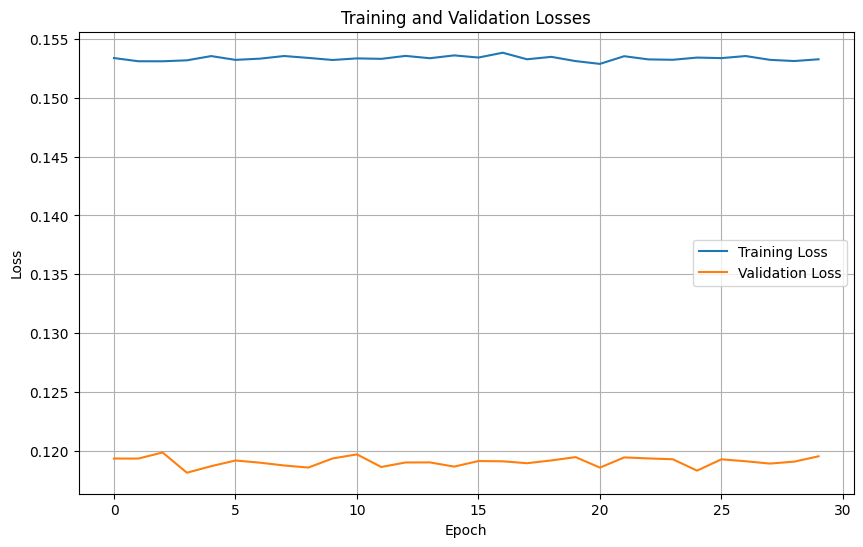

Evaluating model...


Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluation accuracy: 0.0000 (0/173)
Final evaluation accuracy: 0.0000
Generating submission...


Generating predictions:   0%|          | 0/240 [00:00<?, ?it/s]

Submission saved to submission.json
Done!


In [12]:
def main():
    """Main function to run the ARC-AGI-2 solution."""
    # Create datasets
    print("Creating datasets...")
    train_dataset = ARCDataset(train_challenges, train_solutions)
    eval_dataset = ARCDataset(eval_challenges, eval_solutions)
    
    # Create data loaders with optimized batch size
    print("Creating data loaders...")
    train_loader = DataLoader(
        train_dataset, 
        batch_size=8,  # Adjust based on available GPU memory
        shuffle=True, 
        collate_fn=collate_arc_batch
    )
    
    eval_loader = DataLoader(
        eval_dataset, 
        batch_size=8, 
        shuffle=False, 
        collate_fn=collate_arc_batch
    )
    
    # Initialize model with optimized hyperparameters for best accuracy
    print("Initializing model...")
    base_model = TransformationNetwork(
        encoder_dim=128,
        hidden_dim=256,
        max_output_size=(30, 30)
    ).to(device)
    
    maml_model = MAML(
        base_model,
        inner_lr=0.01,  # Learning rate for task adaptation
        meta_lr=0.001   # Learning rate for meta-learning
    )
    
    # Train the model
    print("Starting meta-training...")
    trained_model, training_losses, validation_losses = meta_train(
        maml_model, 
        train_loader, 
        eval_loader, 
        num_epochs=30,  # Adjust based on convergence
        inner_steps=5,  # Number of adaptation steps
        log_interval=5   # How often to log progress
    )
    
    # Evaluate model on the evaluation dataset
    print("Evaluating model...")
    accuracy = evaluate_model(trained_model, eval_loader, num_adaptation_steps=10)
    print(f"Final evaluation accuracy: {accuracy:.4f}")
    
    # Generate submission file
    print("Generating submission...")
    submission = generate_submission(
        trained_model, 
        test_challenges, 
        output_path='submission.json',
        num_adaptation_steps=10  # More steps for better adaptation to test tasks
    )
    
    print("Done!")

if __name__ == "__main__":
    main()